# Kepler Exoplanet Search Results

## Conjunto de datos: Kepler Exoplanet Search Results

### Descripción
#### Context
The Kepler Space Observatory is a NASA-build satellite that was launched in 2009. The telescope is dedicated to searching for exoplanets in star systems besides our own, with the ultimate goal of possibly finding other habitable planets besides our own. The original mission ended in 2013 due to mechanical failures, but the telescope has nevertheless been functional since 2014 on a "K2" extended mission.

Kepler had verified 1284 new exoplanets as of May 2016. As of October 2017 there are over 3000 confirmed exoplanets total (using all detection methods, including ground-based ones). The telescope is still active and continues to collect new data on its extended mission.

#### Content
This dataset is a cumulative record of all observed Kepler "objects of interest" — basically, all of the approximately 10,000 exoplanet candidates Kepler has taken observations on.

This dataset has an extensive data dictionary, which can be accessed <a href="https://exoplanetarchive.ipac.caltech.edu/docs/API_kepcandidate_columns.html"> here<a/> . Highlightable columns of note are:

<ul>
  <li>kepoi_name: A KOI is a target identified by the Kepler Project that displays at least one transit-like sequence within Kepler time-series photometry that appears to be of astrophysical origin and initially consistent with a planetary transit hypothesis</li>
  <li>kepler_name: [These names] are intended to clearly indicate a class of objects that have been confirmed or validated as planets—a step up from the planet candidate designation.</li>
  <li>koi_disposition: The disposition in the literature towards this exoplanet candidate. One of CANDIDATE, FALSE POSITIVE, NOT DISPOSITIONED or CONFIRMED.</li>
  <li>koi_pdisposition: The disposition Kepler data analysis has towards this exoplanet candidate. One of FALSE POSITIVE, NOT DISPOSITIONED, and CANDIDATE.</li>
  <li>koi_score: A value between 0 and 1 that indicates the confidence in the KOI disposition. For CANDIDATEs, a higher value indicates more confidence in its disposition, while for FALSE POSITIVEs, a higher value indicates less confidence in that disposition.</li>
</ul>

#### Acknowledgements
This dataset was published as-is by NASA. You can access the original table here. More data from the Kepler mission is available from the same source <a href="https://exoplanetarchive.ipac.caltech.edu/docs/data.html">here<a/>.

#### Inspiration
<ul>
    <li>How often are exoplanets confirmed in the existing literature disconfirmed by measurements from Kepler? How about the other way round?</li>
    <li>What general characteristics about exoplanets (that we can find) can you derive from this dataset?</li>
    <li>What exoplanets get assigned names in the literature? What is the distribution of confidence scores?</li>
</ul>

See also: the Kepler Labeled Time Series and Open Exoplanets Catalogue datasets.

Descarga de los ficheros
<a href="https://www.kaggle.com/datasets/nasa/kepler-exoplanet-search-results">https://www.kaggle.com/datasets/nasa/kepler-exoplanet-search-results<a/>

## Imports

In [3]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split


from sklearn.ensemble import IsolationForest
from sklearn.experimental import enable_iterative_imputer # Necesario para IterativeImputer
from sklearn.impute import KNNImputer, IterativeImputer


In [4]:
import warnings
# Ignoramos algunos warnings que se producen por invocar el modelo sin el nombre de las características
warnings.filterwarnings('ignore', category=RuntimeWarning, message='Mean of empty slice')

## Funciones auxiliares 

In [4]:
# Construcción de una función que realice el particionado completo
def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(
        df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=strat)
    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(
        test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
    return (train_set, val_set, test_set)

In [5]:
# Función que separa las variables de entrada y salida
def remove_labels(df, label_name):
    X = df.drop(label_name, axis=1)
    y = df[label_name].copy()
    return (X, y)

In [6]:
# Transormador para codificar únicamente las columnas categoricas y devolver un df
class CustomOneHotEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self._oh = OneHotEncoder()
        self._columns = None
        
    def fit(self, X, y=None):
        X_cat = X.select_dtypes(include=['object'])
        self._columns = pd.get_dummies(X_cat).columns
        self._oh.fit(X_cat)
        return self
        
    def transform(self, X, y=None):
        X_copy = X.copy()
        X_cat = X_copy.select_dtypes(include=['object'])
        X_num = X_copy.select_dtypes(exclude=['object'])
        X_cat_oh = self._oh.transform(X_cat)
        X_cat_oh = pd.DataFrame(X_cat_oh.toarray(), 
                                columns=self._columns, 
                                index=X_copy.index)
        X_copy.drop(list(X_cat), axis=1, inplace=True)
        return X_copy.join(X_cat_oh)

In [7]:
# Función que rellena los valores nulos en el DataFrame: 
# Utiliza la mediana para variables numéricas y la moda para columnas categóricas
def fill_null_values(df_to_fill):
    for column in df_to_fill.columns:
        # Verifica si la columna tiene valores nulos
        if df_to_fill[column].isna().any():
            
            # Verificar el tipo de dato de la columna
            if pd.api.types.is_numeric_dtype(df_to_fill[column]):
                # Columna numerica 
                try: 
                    mediana = df_to_fill[column].median()
                    df_to_fill[column] = df_to_fill[column].fillna(mediana)
                    print(f"{column} imputada con la mediana ({mediana:.4f})")
                except:
                    print(f"No se pudo aplicar la mediana a la columna '{column}")
            
            elif df_to_fill[column].dtype == 'object':
                # Columna categorica
                try:
                    # Dado que la moda puede devolver multiples valores, se toma el primero 
                    moda = df_to_fill[column].mode()[0]
                    df_to_fill[column] = df_to_fill[column].fillna(moda)
                    print(f"{column} imputada con la moda ('{moda}').")
                except:
                    print(f"No se pudo aplicar la moda a la columna '{column}")
                    
            else:
                # Caso para otros tipos como booleano, fecha, etc.
                print(f"Columna '{column}': Tipo '{df_to_fill[column].dtype}' no manejado")     

    return df_to_fill

In [8]:
# Funcion para KNN Imputer
def fill_null_values_KNN(df_knn):

    numeric_cols = df_knn.select_dtypes(include=['number']).columns
    categorical_cols = df_knn.select_dtypes(include=['object']).columns
    
    for col in categorical_cols:
        if df_knn[col].isna().any():
            moda = df_knn[col].mode()[0]
            df_knn[col] = df_knn[col].fillna(moda)
            print(f"Columna '{col}' imputada con la moda: {moda}")

    if len(numeric_cols) > 0:
        print("Iniciando imputación KNN para variables numéricas...")
        imputer = KNNImputer(n_neighbors=5, weights="uniform")
        
        df_knn[numeric_cols] = imputer.fit_transform(df_knn[numeric_cols])
        
    return df_knn

In [9]:
# Aplica Capping a una columna usando el método IQR
def iqr_capper(df_in, col_name, factor=1.5):
    Q1 = df_in[col_name].quantile(0.25)
    Q3 = df_in[col_name].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    
    # Recortar los valores fuera de los límites
    df_in[col_name] = np.where(df_in[col_name] > upper_bound, upper_bound, df_in[col_name])
    df_in[col_name] = np.where(df_in[col_name] < lower_bound, lower_bound, df_in[col_name])
    
    return df_in

In [147]:
# Transformador creado para sustituir outliers con la mediana
class SubstituteOutliersMedian(BaseEstimator, TransformerMixin):
    def __init__(self, attributes):
        self.attributes = list(attributes)
    def fit(self, X, y=None):
        # Calculamos cuantiles, límites e medianas por atributo y los guardamos
        Q1 = X[self.attributes].quantile(0.25)
        Q3 = X[self.attributes].quantile(0.75)
        IQR = Q3 - Q1

        self.lim_inf = Q1 - 1.5 * IQR
        self.lim_sup = Q3 + 1.5 * IQR
        self.median = X[self.attributes].median()

        return self
    def transform(self, X, y=None):
        X_copy = X.copy()
    
        for attr in self.attributes:
            is_outlier = (X_copy[attr] < self.lim_inf[attr]) | (X_copy[attr] > self.lim_sup[attr])
            # Reemplazamos solo donde is_outlier == True
            X_copy.loc[is_outlier, attr] = self.median[attr]
        
        return X_copy

In [10]:
# Transformador creado para sustituir outliers con la media
class SubstituteOutliersMean(BaseEstimator, TransformerMixin):
    def __init__(self, attributes):
        self.attributes = list(attributes)
    def fit(self, X, y=None):
        # Calculamos cuantiles, límites e medianas por atributo y los guardamos
        Q1 = X[self.attributes].quantile(0.25)
        Q3 = X[self.attributes].quantile(0.75)
        IQR = Q3 - Q1

        self.lim_inf = Q1 - 1.5 * IQR
        self.lim_sup = Q3 + 1.5 * IQR
        self.mean = X[self.attributes].mean()

        return self
    def transform(self, X, y=None):
        X_copy = X.copy()
    
        for attr in self.attributes:
            is_outlier = (X_copy[attr] < self.lim_inf[attr]) | (X_copy[attr] > self.lim_sup[attr])
            # Reemplazamos solo donde is_outlier == True
            X_copy.loc[is_outlier, attr] = self.mean[attr]
        
        return X_copy

## Lectura del conjunto de datos y exploración inicial

In [11]:
df = pd.read_csv("cumulative.csv")

Primera visualización del conjunto de datos y dimensiones

In [12]:
print("Dimensiones del DataFrame:", df.shape)
print("Primeros 5 registros del DataFrame:")
print(df.head(5))

Dimensiones del DataFrame: (9564, 50)
Primeros 5 registros del DataFrame:
   rowid     kepid kepoi_name   kepler_name koi_disposition koi_pdisposition  \
0      1  10797460  K00752.01  Kepler-227 b       CONFIRMED        CANDIDATE   
1      2  10797460  K00752.02  Kepler-227 c       CONFIRMED        CANDIDATE   
2      3  10811496  K00753.01           NaN  FALSE POSITIVE   FALSE POSITIVE   
3      4  10848459  K00754.01           NaN  FALSE POSITIVE   FALSE POSITIVE   
4      5  10854555  K00755.01  Kepler-664 b       CONFIRMED        CANDIDATE   

   koi_score  koi_fpflag_nt  koi_fpflag_ss  koi_fpflag_co  ...  \
0      1.000              0              0              0  ...   
1      0.969              0              0              0  ...   
2      0.000              0              1              0  ...   
3      0.000              0              1              0  ...   
4      1.000              0              0              0  ...   

   koi_steff_err2  koi_slogg  koi_slogg_err1  ko

Visualicemos los nombres de todas las variables

In [13]:
print(df.columns)

Index(['rowid', 'kepid', 'kepoi_name', 'kepler_name', 'koi_disposition',
       'koi_pdisposition', 'koi_score', 'koi_fpflag_nt', 'koi_fpflag_ss',
       'koi_fpflag_co', 'koi_fpflag_ec', 'koi_period', 'koi_period_err1',
       'koi_period_err2', 'koi_time0bk', 'koi_time0bk_err1',
       'koi_time0bk_err2', 'koi_impact', 'koi_impact_err1', 'koi_impact_err2',
       'koi_duration', 'koi_duration_err1', 'koi_duration_err2', 'koi_depth',
       'koi_depth_err1', 'koi_depth_err2', 'koi_prad', 'koi_prad_err1',
       'koi_prad_err2', 'koi_teq', 'koi_teq_err1', 'koi_teq_err2', 'koi_insol',
       'koi_insol_err1', 'koi_insol_err2', 'koi_model_snr', 'koi_tce_plnt_num',
       'koi_tce_delivname', 'koi_steff', 'koi_steff_err1', 'koi_steff_err2',
       'koi_slogg', 'koi_slogg_err1', 'koi_slogg_err2', 'koi_srad',
       'koi_srad_err1', 'koi_srad_err2', 'ra', 'dec', 'koi_kepmag'],
      dtype='object')


Reindexamos con la columna de índices que trae el dataset

In [14]:
# Colocamos la columna rowid como indice
df.set_index("rowid", inplace=True)
df

,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
rowid,,,,,,,,,,,,,,,,,,,,,
1,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
3,10811496,K00753.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
4,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
5,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9560,10031643,K07984.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,0,0,1,...,-152.0,4.296,0.231,-0.189,1.088,0.313,-0.228,298.74921,46.973351,14.478
9561,10090151,K07985.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,1,0,...,-166.0,4.529,0.035,-0.196,0.903,0.237,-0.079,297.18875,47.093819,14.082
9562,10128825,K07986.01,NaN,CANDIDATE,CANDIDATE,0.497,0,0,0,0,...,-220.0,4.444,0.056,-0.224,1.031,0.341,-0.114,286.50937,47.163219,14.757


In [15]:
df.describe()

,kepid,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
count,9.564000e+03,8054.000000,9564.000000,9564.000000,9564.000000,9564.000000,9564.000000,9110.000000,9110.000000,9564.000000,...,9081.000000,9201.000000,9096.000000,9096.000000,9201.000000,9096.000000,9096.000000,9564.000000,9564.000000,9563.000000
mean,7.690628e+06,0.480829,0.188206,0.231598,0.194898,0.120033,75.671358,0.002148,-0.002148,166.183251,...,-162.265059,4.310157,0.120738,-0.143161,1.728712,0.362292,-0.394806,292.060163,43.810433,14.264606
std,2.653459e+06,0.476928,0.390897,0.421875,0.396143,0.325018,1334.744046,0.008236,0.008236,67.918960,...,72.746348,0.432606,0.132837,0.085477,6.127185,0.930870,2.168213,4.766657,3.601243,1.385448
min,7.574500e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.241843,0.000000,-0.172500,120.515914,...,-1762.000000,0.047000,0.000000,-1.207000,0.109000,0.000000,-116.137000,279.852720,36.577381,6.966000
25%,5.556034e+06,0.000000,0.000000,0.000000,0.000000,0.000000,2.733684,0.000005,-0.000276,132.761718,...,-198.000000,4.218000,0.042000,-0.196000,0.829000,0.129000,-0.250000,288.660770,40.777173,13.440000
50%,7.906892e+06,0.334000,0.000000,0.000000,0.000000,0.000000,9.752831,0.000035,-0.000035,137.224595,...,-160.000000,4.438000,0.070000,-0.128000,1.000000,0.251000,-0.111000,292.261125,43.677504,14.520000
75%,9.873066e+06,0.998000,0.000000,0.000000,0.000000,0.000000,40.715178,0.000276,-0.000005,170.694603,...,-114.000000,4.543000,0.149000,-0.088000,1.345000,0.364000,-0.069000,295.859160,46.714611,15.322000
max,1.293514e+07,1.000000,1.000000,1.000000,1.000000,1.000000,129995.778400,0.172500,0.000000,1472.522306,...,0.000000,5.364000,1.472000,0.000000,229.908000,33.091000,0.000000,301.720760,52.336010,20.003000


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9564 entries, 1 to 9564
Data columns (total 49 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   kepid              9564 non-null   int64  
 1   kepoi_name         9564 non-null   object 
 2   kepler_name        2294 non-null   object 
 3   koi_disposition    9564 non-null   object 
 4   koi_pdisposition   9564 non-null   object 
 5   koi_score          8054 non-null   float64
 6   koi_fpflag_nt      9564 non-null   int64  
 7   koi_fpflag_ss      9564 non-null   int64  
 8   koi_fpflag_co      9564 non-null   int64  
 9   koi_fpflag_ec      9564 non-null   int64  
 10  koi_period         9564 non-null   float64
 11  koi_period_err1    9110 non-null   float64
 12  koi_period_err2    9110 non-null   float64
 13  koi_time0bk        9564 non-null   float64
 14  koi_time0bk_err1   9110 non-null   float64
 15  koi_time0bk_err2   9110 non-null   float64
 16  koi_impact         9201 non-n

## Imputación de datos faltantes

In [17]:
# Numero de nulos en cada columna
df.isna().sum()

kepid                   0
kepoi_name              0
kepler_name          7270
koi_disposition         0
koi_pdisposition        0
koi_score            1510
koi_fpflag_nt           0
koi_fpflag_ss           0
koi_fpflag_co           0
koi_fpflag_ec           0
koi_period              0
koi_period_err1       454
koi_period_err2       454
koi_time0bk             0
koi_time0bk_err1      454
koi_time0bk_err2      454
koi_impact            363
koi_impact_err1       454
koi_impact_err2       454
koi_duration            0
koi_duration_err1     454
koi_duration_err2     454
koi_depth             363
koi_depth_err1        454
koi_depth_err2        454
koi_prad              363
koi_prad_err1         363
koi_prad_err2         363
koi_teq               363
koi_teq_err1         9564
koi_teq_err2         9564
koi_insol             321
koi_insol_err1        321
koi_insol_err2        321
koi_model_snr         363
koi_tce_plnt_num      346
koi_tce_delivname     346
koi_steff             363
koi_steff_er

Veamos cuáles son los valores con mayor cantidad de valores nulos

In [18]:
print("Resumen de valores nulos por columna (top 10):")
print(df.isnull().sum().sort_values(ascending=False).head(10))

Resumen de valores nulos por columna (top 10):
koi_teq_err2      9564
koi_teq_err1      9564
kepler_name       7270
koi_score         1510
koi_steff_err2     483
koi_srad_err2      468
koi_srad_err1      468
koi_slogg_err2     468
koi_slogg_err1     468
koi_steff_err1     468
dtype: int64


Se ha observado que las columnas *koi_teq_err2* y *koi_teq_err1* contienen valores nulos en la totalidad de los registros (9564).

Por otro lado, los valores nulos para las variables kepler_name y koi_score representan:

In [19]:
total_registros = 9564
num_null_kepler_name = 7270
porcentaje_kepler_name = (num_null_kepler_name / total_registros) * 100

print(f"El porcentaje de valores nulos para kepler_name es: {porcentaje_kepler_name:.2f}%")

El porcentaje de valores nulos para kepler_name es: 76.01%


In [20]:
num_null_koi_score = 1510
porcentaje_koi_score = (num_null_koi_score / total_registros) * 100

print(f"El porcentaje de valores nulos para kepler_name es: {porcentaje_koi_score:.2f}%")

El porcentaje de valores nulos para kepler_name es: 15.79%


In [22]:
# Copiamos el conjunto de datos para no alterar el original
df_copy = df.copy()

Dada la alta proporción de datos faltantes, se procede a la eliminación de las siguientes columnas:
* *koi_teq_err1* y *koi_teq_err2*: Eliminadas por tener el 100% de valores nulos.
* *kepler_name*: Eliminada por su alto porcentaje de valores nulos (76.01%), lo que limita su utilidad en el modelado.

**Nota:** La columna *koi_score* se mantendrá, ya que su porcentaje de nulos (15.79%) es manejable a través de técnicas de imputación.

In [23]:
# Eliminamos la columna "kepler_name", "koi_teq_err1", "koi_teq_err2" 
df_copy = df_copy.drop(["kepler_name","koi_teq_err1","koi_teq_err2"], axis=1)

División del conjunto de datos en X (features) y (target)
El target es *koi_disposition*

In [24]:
# División del conjunto de datos en X, y
X_df, y_df = remove_labels(df_copy, "koi_disposition")
X_df

,kepid,kepoi_name,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
rowid,,,,,,,,,,,,,,,,,,,,,
1,10797460,K00752.01,CANDIDATE,1.000,0,0,0,0,9.488036,2.775000e-05,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,10797460,K00752.02,CANDIDATE,0.969,0,0,0,0,54.418383,2.479000e-04,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
3,10811496,K00753.01,FALSE POSITIVE,0.000,0,1,0,0,19.899140,1.494000e-05,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
4,10848459,K00754.01,FALSE POSITIVE,0.000,0,1,0,0,1.736952,2.630000e-07,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
5,10854555,K00755.01,CANDIDATE,1.000,0,0,0,0,2.525592,3.761000e-06,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9560,10031643,K07984.01,FALSE POSITIVE,0.000,0,0,0,1,8.589871,1.846000e-04,...,-152.0,4.296,0.231,-0.189,1.088,0.313,-0.228,298.74921,46.973351,14.478
9561,10090151,K07985.01,FALSE POSITIVE,0.000,0,1,1,0,0.527699,1.160000e-07,...,-166.0,4.529,0.035,-0.196,0.903,0.237,-0.079,297.18875,47.093819,14.082
9562,10128825,K07986.01,CANDIDATE,0.497,0,0,0,0,1.739849,1.780000e-05,...,-220.0,4.444,0.056,-0.224,1.031,0.341,-0.114,286.50937,47.163219,14.757


**La imputación se realizará solo sobre las features (X_df)**

### Imputación simple

#### Observación importante:

Dado que varias columnas contienen información astronómica relevante para el análisis, se optó por un método de imputación que aprovecha las relaciones entre variables, en lugar de reemplazar los valores faltantes con una medida univariada como la media o la mediana (imputación simple). Ya que si bien son rápidos, ignoran la estructura multivariada del dataset, lo que puede producir valores poco realistas o físicamente inconsistentes. Por ende, la imputación simple no se implementó para manejar los datos faltantes restantes, pero se colocó el código que se desarrolló para esto como una primer propuesta.

La imputación simple se realiza con base en el tipo de variable:
* Si la variable es numérica, aplicaremos la mediana 
* Si la variable es categóricas, aplicaremos la moda 

In [25]:
numerical_na = X_df.select_dtypes(include=np.number).isnull().sum()[X_df.select_dtypes(include=np.number).isnull().sum() > 0].index.tolist()
categorical_na = X_df.select_dtypes(include=['object']).isnull().sum()[X_df.select_dtypes(include=['object']).isnull().sum() > 0].index.tolist()

print("\nCOLUMNAS NUMÉRICAS CON NULOS")
print(numerical_na)
print("\nCOLUMNAS CATEGÓRICAS CON NULOS")
print(categorical_na)


COLUMNAS NUMÉRICAS CON NULOS
['koi_score', 'koi_period_err1', 'koi_period_err2', 'koi_time0bk_err1', 'koi_time0bk_err2', 'koi_impact', 'koi_impact_err1', 'koi_impact_err2', 'koi_duration_err1', 'koi_duration_err2', 'koi_depth', 'koi_depth_err1', 'koi_depth_err2', 'koi_prad', 'koi_prad_err1', 'koi_prad_err2', 'koi_teq', 'koi_insol', 'koi_insol_err1', 'koi_insol_err2', 'koi_model_snr', 'koi_tce_plnt_num', 'koi_steff', 'koi_steff_err1', 'koi_steff_err2', 'koi_slogg', 'koi_slogg_err1', 'koi_slogg_err2', 'koi_srad', 'koi_srad_err1', 'koi_srad_err2', 'koi_kepmag']

COLUMNAS CATEGÓRICAS CON NULOS
['koi_tce_delivname']


Llamamos a la función para imputar sobre X_df, que se encuentra definida en la sección *Funciones auxiliares*

In [ ]:
#X_df_imputed = fill_null_values(X_df)

In [ ]:
#print("Nulos después de la imputación simple:")
#print(X_df_imputed.isnull().sum())

### Implementando KNN Imputer

En un conjunto de datos como el de Kepler, donde muchas variables físicas están correlacionadas entre sí (por ejemplo, periodos orbitales, radios, temperaturas, profundidades de tránsito, etc.), es preferible utilizar un método que considere simultáneamente varias características al momento de inferir valores faltantes, como se muestra a continuación:

In [26]:
df_knn= fill_null_values_KNN(X_df)

Columna 'koi_tce_delivname' imputada con la moda: q1_q17_dr25_tce
Iniciando imputación KNN para variables numéricas...


Veamos ahora el DataFrame resultante después de imputar

In [125]:
df_knn

,kepid,kepoi_name,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
rowid,,,,,,,,,,,,,,,,,,,,,
1,10797460.0,K00752.01,CANDIDATE,1.000,0.0,0.0,0.0,0.0,9.488036,2.775000e-05,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,10797460.0,K00752.02,CANDIDATE,0.969,0.0,0.0,0.0,0.0,54.418383,2.479000e-04,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
3,10811496.0,K00753.01,FALSE POSITIVE,0.000,0.0,1.0,0.0,0.0,19.899140,1.494000e-05,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
4,10848459.0,K00754.01,FALSE POSITIVE,0.000,0.0,1.0,0.0,0.0,1.736952,2.630000e-07,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
5,10854555.0,K00755.01,CANDIDATE,1.000,0.0,0.0,0.0,0.0,2.525592,3.761000e-06,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9560,10031643.0,K07984.01,FALSE POSITIVE,0.000,0.0,0.0,0.0,1.0,8.589871,1.846000e-04,...,-152.0,4.296,0.231,-0.189,1.088,0.313,-0.228,298.74921,46.973351,14.478
9561,10090151.0,K07985.01,FALSE POSITIVE,0.000,0.0,1.0,1.0,0.0,0.527699,1.160000e-07,...,-166.0,4.529,0.035,-0.196,0.903,0.237,-0.079,297.18875,47.093819,14.082
9562,10128825.0,K07986.01,CANDIDATE,0.497,0.0,0.0,0.0,0.0,1.739849,1.780000e-05,...,-220.0,4.444,0.056,-0.224,1.031,0.341,-0.114,286.50937,47.163219,14.757


In [55]:
# Visualizamos de nuevo el número de nulos en cada columna
df_knn.isna().sum()

kepid                0
kepoi_name           0
koi_pdisposition     0
koi_score            0
koi_fpflag_nt        0
koi_fpflag_ss        0
koi_fpflag_co        0
koi_fpflag_ec        0
koi_period           0
koi_period_err1      0
koi_period_err2      0
koi_time0bk          0
koi_time0bk_err1     0
koi_time0bk_err2     0
koi_impact           0
koi_impact_err1      0
koi_impact_err2      0
koi_duration         0
koi_duration_err1    0
koi_duration_err2    0
koi_depth            0
koi_depth_err1       0
koi_depth_err2       0
koi_prad             0
koi_prad_err1        0
koi_prad_err2        0
koi_teq              0
koi_insol            0
koi_insol_err1       0
koi_insol_err2       0
koi_model_snr        0
koi_tce_plnt_num     0
koi_tce_delivname    0
koi_steff            0
koi_steff_err1       0
koi_steff_err2       0
koi_slogg            0
koi_slogg_err1       0
koi_slogg_err2       0
koi_srad             0
koi_srad_err1        0
koi_srad_err2        0
ra                   0
dec        

## Cálculo de estadísticas descriptivas & transformación de variables

Recordemos que la variable *koi_disposition* es nuestro target, la cual, desde el DataFrame original no tiene ningún valor nulo

In [126]:
df['koi_disposition'].isna().sum()

np.int64(0)

Exploremos las diferentes clases que existen sobre el target y el número de registros correspondientes a cada una

In [127]:
df["koi_disposition"].value_counts()

koi_disposition
FALSE POSITIVE    5023
CONFIRMED         2293
CANDIDATE         2248
Name: count, dtype: int64

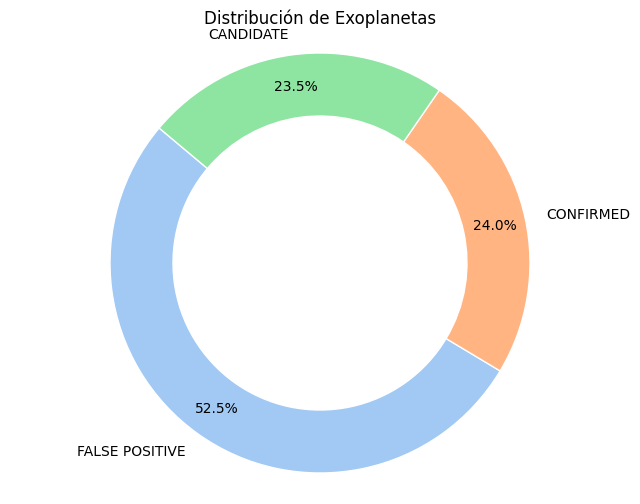

In [35]:
conteo_planetas = df['koi_disposition'].value_counts().values
categorias = df['koi_disposition'].value_counts().index
colors = sns.color_palette("pastel", n_colors=len(sizes))

plt.figure(figsize=(8, 6))
plt.pie(conteo_planetas, 
        labels=categorias, 
        colors=colors, 
        autopct='%1.1f%%', 
        startangle=140, 
        pctdistance=0.85,
        wedgeprops=dict(width=0.3, edgecolor='white'))
plt.axis('equal') 
plt.title('Distribución de Exoplanetas')
plt.show()

Ahora veamos los cambios generales en la descripción en la version del DataFrame ya imputada 

In [61]:
df_knn.describe()

,kepid,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
count,9.564000e+03,9564.000000,9564.000000,9564.000000,9564.000000,9564.000000,9564.000000,9564.000000,9564.000000,9564.000000,...,9564.000000,9564.000000,9564.000000,9564.000000,9564.000000,9564.000000,9564.000000,9564.000000,9564.000000,9564.000000
mean,7.690628e+06,0.498591,0.188206,0.231598,0.194898,0.120033,75.671358,0.002146,-0.002146,166.183251,...,-162.393747,4.310080,0.121054,-0.143411,1.726396,0.361962,-0.393325,292.060163,43.810433,14.264827
std,2.653459e+06,0.452932,0.390897,0.421875,0.396143,0.325018,1334.744046,0.008085,0.008085,67.918960,...,71.380320,0.426529,0.130501,0.083924,6.028906,0.912352,2.122219,4.766657,3.601243,1.385544
min,7.574500e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.241843,0.000000,-0.172500,120.515914,...,-1762.000000,0.047000,0.000000,-1.207000,0.109000,0.000000,-116.137000,279.852720,36.577381,6.966000
25%,5.556034e+06,0.000000,0.000000,0.000000,0.000000,0.000000,2.733684,0.000006,-0.000319,132.761718,...,-197.000000,4.218000,0.044000,-0.195000,0.833000,0.135000,-0.260150,288.660770,40.777173,13.440000
50%,7.906892e+06,0.573500,0.000000,0.000000,0.000000,0.000000,9.752831,0.000039,-0.000039,137.224595,...,-160.000000,4.438000,0.072000,-0.132000,1.000000,0.253000,-0.114000,292.261125,43.677504,14.520000
75%,9.873066e+06,0.995000,0.000000,0.000000,0.000000,0.000000,40.715178,0.000319,-0.000006,170.694603,...,-116.000000,4.540000,0.149000,-0.090000,1.356000,0.365000,-0.070000,295.859160,46.714611,15.322000
max,1.293514e+07,1.000000,1.000000,1.000000,1.000000,1.000000,129995.778400,0.172500,0.000000,1472.522306,...,0.000000,5.364000,1.472000,0.000000,229.908000,33.091000,0.000000,301.720760,52.336010,20.003000


In [62]:
df_knn.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9564 entries, 1 to 9564
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   kepid              9564 non-null   float64
 1   kepoi_name         9564 non-null   object 
 2   koi_pdisposition   9564 non-null   object 
 3   koi_score          9564 non-null   float64
 4   koi_fpflag_nt      9564 non-null   float64
 5   koi_fpflag_ss      9564 non-null   float64
 6   koi_fpflag_co      9564 non-null   float64
 7   koi_fpflag_ec      9564 non-null   float64
 8   koi_period         9564 non-null   float64
 9   koi_period_err1    9564 non-null   float64
 10  koi_period_err2    9564 non-null   float64
 11  koi_time0bk        9564 non-null   float64
 12  koi_time0bk_err1   9564 non-null   float64
 13  koi_time0bk_err2   9564 non-null   float64
 14  koi_impact         9564 non-null   float64
 15  koi_impact_err1    9564 non-null   float64
 16  koi_impact_err2    9564 non-n

Por ahora, nos concentraremos en el raw_data, por lo que crearemos un DataFrame sin las columnas que contengan errores de medición

In [27]:
df_copy2 = df_knn.copy()

In [28]:
df_copy2 = df_copy.drop(["koi_period_err1","koi_period_err2",
                         "koi_time0bk_err1","koi_time0bk_err2",
                         "koi_impact_err1","koi_impact_err2",
                         "koi_duration_err1","koi_duration_err2",
                         "koi_depth_err1","koi_depth_err2",
                         "koi_prad_err1","koi_prad_err2",
                         "koi_insol_err1","koi_insol_err2",
                         "koi_steff_err1","koi_steff_err2",
                         "koi_slogg_err1","koi_slogg_err2",
                         "koi_srad_err1","koi_srad_err2"
                         ], axis=1)

In [130]:
df_copy2

,kepid,kepoi_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,...,koi_insol,koi_model_snr,koi_tce_plnt_num,koi_tce_delivname,koi_steff,koi_slogg,koi_srad,ra,dec,koi_kepmag
rowid,,,,,,,,,,,,,,,,,,,,,
1,10797460,K00752.01,CONFIRMED,CANDIDATE,1.000,0,0,0,0,9.488036,...,93.59,35.8,1.0,q1_q17_dr25_tce,5455.0,4.467,0.927,291.93423,48.141651,15.347
2,10797460,K00752.02,CONFIRMED,CANDIDATE,0.969,0,0,0,0,54.418383,...,9.11,25.8,2.0,q1_q17_dr25_tce,5455.0,4.467,0.927,291.93423,48.141651,15.347
3,10811496,K00753.01,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,19.899140,...,39.30,76.3,1.0,q1_q17_dr25_tce,5853.0,4.544,0.868,297.00482,48.134129,15.436
4,10848459,K00754.01,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,1.736952,...,891.96,505.6,1.0,q1_q17_dr25_tce,5805.0,4.564,0.791,285.53461,48.285210,15.597
5,10854555,K00755.01,CONFIRMED,CANDIDATE,1.000,0,0,0,0,2.525592,...,926.16,40.9,1.0,q1_q17_dr25_tce,6031.0,4.438,1.046,288.75488,48.226200,15.509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9560,10031643,K07984.01,FALSE POSITIVE,FALSE POSITIVE,0.000,0,0,0,1,8.589871,...,176.40,8.4,1.0,q1_q17_dr25_tce,5638.0,4.296,1.088,298.74921,46.973351,14.478
9561,10090151,K07985.01,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,1,0,0.527699,...,4500.53,453.3,1.0,q1_q17_dr25_tce,5638.0,4.529,0.903,297.18875,47.093819,14.082
9562,10128825,K07986.01,CANDIDATE,CANDIDATE,0.497,0,0,0,0,1.739849,...,1585.81,10.6,1.0,q1_q17_dr25_tce,6119.0,4.444,1.031,286.50937,47.163219,14.757


In [ ]:
df_copy2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9564 entries, 1 to 9564
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   kepid              9564 non-null   int64  
 1   kepoi_name         9564 non-null   object 
 2   koi_disposition    9564 non-null   object 
 3   koi_pdisposition   9564 non-null   object 
 4   koi_score          8054 non-null   float64
 5   koi_fpflag_nt      9564 non-null   int64  
 6   koi_fpflag_ss      9564 non-null   int64  
 7   koi_fpflag_co      9564 non-null   int64  
 8   koi_fpflag_ec      9564 non-null   int64  
 9   koi_period         9564 non-null   float64
 10  koi_time0bk        9564 non-null   float64
 11  koi_impact         9201 non-null   float64
 12  koi_duration       9564 non-null   float64
 13  koi_depth          9201 non-null   float64
 14  koi_prad           9201 non-null   float64
 15  koi_teq            9201 non-null   float64
 16  koi_insol          9243 non-n

In [65]:
# veamos la disposicion en el archivo y usando datos de Kepler
df_copy2[["koi_disposition", "koi_pdisposition"]].apply(pd.value_counts)


/var/folders/96/j0wyjygn5jl9stf8cvdvfzwm0000gn/T/ipykernel_18529/194564988.py:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  df_copy2[["koi_disposition", "koi_pdisposition"]].apply(pd.value_counts)
/var/folders/96/j0wyjygn5jl9stf8cvdvfzwm0000gn/T/ipykernel_18529/194564988.py:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  df_copy2[["koi_disposition", "koi_pdisposition"]].apply(pd.value_counts)


,koi_disposition,koi_pdisposition
CANDIDATE,2248,4496.0
CONFIRMED,2293,NaN
FALSE POSITIVE,5023,5068.0


Notamos que al usar datos de Kepler el número de Falsos positivos se mantiene relativamente cercano, pero el numero de posibles candidatos se duplica

In [66]:
#veamos que que tanto coinciden ambas disposiciones 
coin_percent = ((df_copy2["koi_disposition"] == df_copy2["koi_pdisposition"]).mean())*100
coin_percent

np.float64(76.02467586783771)

In [67]:
#compactamos las variables en subgrupos 
disposition = ['koi_disposition','koi_pdisposition']
koi_flags = ['koi_fpflag_nt','koi_fpflag_ss','koi_fpflag_co','koi_fpflag_ec']
trans_prop = ['koi_period','koi_time0bk','koi_impact','koi_duration','koi_depth','koi_prad','koi_teq','koi_insol']
stellar_par = ['koi_steff','koi_slogg','koi_srad']


In [68]:
#veamos que tan común es cada Flag 
flag_freq = (df_copy2[koi_flags].mean())*100
flag_freq


koi_fpflag_nt    18.820577
koi_fpflag_ss    23.159766
koi_fpflag_co    19.489753
koi_fpflag_ec    12.003346
dtype: float64

la bandera ss (stelar eclipse) parece ser la mas frecuente de todas, indicando que muchas de las observaciones son probablemente causadas por una binaria eclipsada.

In [69]:
#veamos cuantas de estas observaciones tienen mas de una flag 
df_copy2[koi_flags].sum(axis=1).value_counts()


0    4560
1    3479
2    1031
3     490
4       4
Name: count, dtype: int64

encontramos 4 observaciones con las 4 flags estas seguramente son falsos positivos!

In [70]:
#veamos que hay de las propiedades transitivas
df_copy2[trans_prop].describe()

,koi_period,koi_time0bk,koi_impact,koi_duration,koi_depth,koi_prad,koi_teq,koi_insol
count,9564.000000,9564.000000,9201.000000,9564.000000,9.201000e+03,9201.000000,9201.000000,9.243000e+03
mean,75.671358,166.183251,0.735105,5.621606,2.379134e+04,102.891778,1085.385828,7.745737e+03
std,1334.744046,67.918960,3.348832,6.471554,8.224268e+04,3077.639126,856.351161,1.592047e+05
min,0.241843,120.515914,0.000000,0.052000,0.000000e+00,0.080000,25.000000,0.000000e+00
25%,2.733684,132.761718,0.197000,2.437750,1.599000e+02,1.400000,539.000000,2.015000e+01
50%,9.752831,137.224595,0.537000,3.792600,4.211000e+02,2.390000,878.000000,1.416000e+02
75%,40.715178,170.694603,0.889000,6.276500,1.473400e+03,14.930000,1379.000000,8.702900e+02
max,129995.778400,1472.522306,100.806000,138.540000,1.541400e+06,200346.000000,14667.000000,1.094755e+07


In [71]:
#que tal algo un poco mas especifico
df_copy2[trans_prop].skew()


koi_period      96.459326
koi_time0bk      3.682070
koi_impact      23.505943
koi_duration     5.928765
koi_depth        5.260652
koi_prad        52.118954
koi_teq          3.505694
koi_insol       49.947777
dtype: float64

In [72]:
df_copy2[trans_prop].kurt() #insights tbd

koi_period      9389.730946
koi_time0bk       25.004265
koi_impact       599.057117
koi_duration      64.124995
koi_depth         38.519360
koi_prad        2974.910711
koi_teq           27.687597
koi_insol       2965.678172
dtype: float64

In [73]:
#veamos la correlacion entre los parametros estelares y los de transicion
df_copy2[trans_prop + stellar_par].corr()


,koi_period,koi_time0bk,koi_impact,koi_duration,koi_depth,koi_prad,koi_teq,koi_insol,koi_steff,koi_slogg,koi_srad
koi_period,1.000000,0.095580,0.004928,0.037302,-0.009180,0.005135,-0.049097,-0.002603,-0.013552,0.001877,-0.000993
koi_time0bk,0.095580,1.000000,0.049241,0.216271,-0.051015,0.034992,-0.324462,-0.022279,0.008367,-0.006220,-0.004924
koi_impact,0.004928,0.049241,1.000000,0.036955,0.005595,0.677380,-0.009982,-0.003659,0.016070,-0.059275,0.022645
koi_duration,0.037302,0.216271,0.036955,1.000000,0.067275,0.036573,-0.194730,-0.018973,0.106203,-0.122239,0.013675
koi_depth,-0.009180,-0.051015,0.005595,0.067275,1.000000,0.002558,0.080735,-0.006310,0.113608,-0.008365,-0.016826
koi_prad,0.005135,0.034992,0.677380,0.036573,0.002558,1.000000,-0.001249,0.002989,-0.013025,-0.097329,0.056669
koi_teq,-0.049097,-0.324462,-0.009982,-0.194730,0.080735,-0.001249,1.000000,0.422720,0.240061,-0.527374,0.439855
koi_insol,-0.002603,-0.022279,-0.003659,-0.018973,-0.006310,0.002989,0.422720,1.000000,-0.057205,-0.285928,0.530914
koi_steff,-0.013552,0.008367,0.016070,0.106203,0.113608,-0.013025,0.240061,-0.057205,1.000000,-0.139534,-0.117195
koi_slogg,0.001877,-0.006220,-0.059275,-0.122239,-0.008365,-0.097329,-0.527374,-0.285928,-0.139534,1.000000,-0.639253


In [74]:
#veamos planetas que reciben luz solar similar a la de la tierra
hab = df_copy2[(df_copy2['koi_insol'] > 0.5) & (df_copy2['koi_insol'] < 2)]
hab['koi_disposition'].value_counts().sum()


np.int64(611)

In [75]:
df_copy2.columns

Index(['kepid', 'kepoi_name', 'koi_disposition', 'koi_pdisposition',
       'koi_score', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co',
       'koi_fpflag_ec', 'koi_period', 'koi_time0bk', 'koi_impact',
       'koi_duration', 'koi_depth', 'koi_prad', 'koi_teq', 'koi_insol',
       'koi_model_snr', 'koi_tce_plnt_num', 'koi_tce_delivname', 'koi_steff',
       'koi_slogg', 'koi_srad', 'ra', 'dec', 'koi_kepmag'],
      dtype='object')

In [76]:
df_copy2['kepid'].value_counts().sum()

np.int64(9564)

Con esto vemos que de los 9218 planetas registrados 533 cumplen condicion solar para ser habitables

Empecemos a transformar

In [77]:
#escalemos las variables numericas, en particular propiedades transitivas que vimos tiene Kurtosis alta
numeric_cols = trans_prop + stellar_par


In [78]:
scaler = RobustScaler()
df_scaled = df_copy2.copy()  #no nos metemos con la copia de la copia
df_scaled[numeric_cols] = scaler.fit_transform(df_copy2[numeric_cols])


In [79]:
df_scaled[numeric_cols]

,koi_period,koi_time0bk,koi_impact,koi_duration,koi_depth,koi_prad,koi_teq,koi_insol,koi_steff,koi_slogg,koi_srad
rowid,,,,,,,,,,,
1,-0.006972,0.878239,-0.565029,-0.217545,0.148230,-0.009608,-0.101190,-0.056473,-0.389027,0.089231,-0.141473
2,1.175982,0.666684,0.070809,0.186102,0.345413,0.032520,-0.517857,-0.155845,-0.389027,0.089231,-0.141473
3,0.267138,1.018263,0.624277,-0.523712,7.923791,0.902439,-0.285714,-0.120333,0.107232,0.326154,-0.255814
4,-0.211047,0.872145,1.067919,-0.361105,5.830301,2.296378,0.615476,0.882631,0.047382,0.387692,-0.405039
5,-0.190283,0.906099,0.236994,-0.556978,0.138713,0.026608,0.628571,0.922860,0.329177,0.000000,0.089147
...,...,...,...,...,...,...,...,...,...,...,...
9560,-0.030619,-0.137308,0.329480,0.263992,-0.253826,-0.094605,0.060714,0.040934,-0.160848,-0.436923,0.170543
9561,-0.242885,-0.145507,1.033237,-0.148616,0.881690,1.992609,1.440476,5.127308,-0.160848,0.280000,-0.187984
9562,-0.210971,-0.111337,-0.713873,-0.176776,-0.283670,-0.123429,0.869048,1.698791,0.438903,0.018462,0.060078


In [80]:
#solo por curiosidad veamos la gravedad en la superficie de los planetas, para esto debemos deshacer el log base 10 en el que vienen
df_copy2['surface_gravity'] = 10 ** df_copy2['koi_slogg']
df_copy2['surface_gravity']


rowid
1       29308.932453
2       29308.932453
3       34994.516703
4       36643.757465
5       27415.741719
            ...     
9560    19769.696401
9561    33806.483621
9562    27797.132678
9563    27989.813196
9564    24266.100951
Name: surface_gravity, Length: 9564, dtype: float64

In [81]:
#pero esto esta en cm/s^2 para verlo en m/s^2
df_copy2['surface_gravity']/100

rowid
1       293.089325
2       293.089325
3       349.945167
4       366.437575
5       274.157417
           ...    
9560    197.696964
9561    338.064836
9562    277.971327
9563    279.898132
9564    242.661010
Name: surface_gravity, Length: 9564, dtype: float64

In [82]:
#vemos las estadisticas descriptivas de esto
(df_copy2['surface_gravity']/100).describe()

count    9201.000000
mean      264.776578
std       148.926286
min         0.011143
25%       165.196180
50%       274.157417
75%       349.140315
max      2312.064790
Name: surface_gravity, dtype: float64

Vemos que presentan valores de gravedad extremos y similares entre sí

In [83]:
#clasifiquemos a los planetas de acuerdo a su tamaño
bins = [0, 1.25, 2, 4, 10, 20]
labels = ['Earth-like', 'Super-Earth', 'Sub-Neptune', 'Gas Giant', 'Super Jupiter']
df_copy2['radius_class'] = pd.cut(df_copy2['koi_prad'], bins=bins, labels=labels)


la clasificacion utiliza una unidad especial conocida como earth Radii 
0 - 1.25 tamaño tierra
1.25 - 2 super tierra
2 - 4 sub neptunos
4 - 10 gigantes gaseosos 
10 - 20 gigantes gaseosos grandes ("llamados super jupiters")

In [84]:
df_copy2['radius_class'].value_counts()

radius_class
Sub-Neptune      2166
Super-Earth      1991
Earth-like       1833
Gas Giant         649
Super Jupiter     459
Name: count, dtype: int64

In [85]:
df_copy2.columns

Index(['kepid', 'kepoi_name', 'koi_disposition', 'koi_pdisposition',
       'koi_score', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co',
       'koi_fpflag_ec', 'koi_period', 'koi_time0bk', 'koi_impact',
       'koi_duration', 'koi_depth', 'koi_prad', 'koi_teq', 'koi_insol',
       'koi_model_snr', 'koi_tce_plnt_num', 'koi_tce_delivname', 'koi_steff',
       'koi_slogg', 'koi_srad', 'ra', 'dec', 'koi_kepmag', 'surface_gravity',
       'radius_class'],
      dtype='object')

In [86]:
#creamos la columna que codifica lo que ya habiamos sacado sobre la zona habitable
df_copy2['habitable_zone'] = (df_copy2['koi_insol'].between(0.25, 2) &
    df_copy2['koi_teq'].between(180, 310)
)

#### Hipótesis 1

Hecho este análisis, planteamos lo siguiente:

**Hipótesis**: Existen exoplanetas habitables comparando temperatura de equilibrio (koi_teq) y radiación incidente (koi_insol).

Para evaluar si el catálogo contiene planetas dentro de la zona habitable, utilizamos dos parámetros físicos:

- **Temperatura de equilibrio (koi_teq)**  
- **Radiación incidente (koi_insol)**

Ambos son fundamentales para estimar si un planeta podría mantener agua líquida en su superficie.

Definimos una zona habitable aproximada usando:

- koi_insol entre **0.25 y 2** (radiación entre Marte y Venus).  
- koi_teq entre **180 K y 310 K** (rango donde el agua podría estar en estado líquido).

Luego usando crosstab analizamos qué tipos de planetas caen dentro de esta zona

In [87]:
pd.crosstab(df_copy2['radius_class'], df_copy2['habitable_zone'])
#con esto podremos ver por tamaño cuales estan en la zona habitable

habitable_zone,False,True
radius_class,,
Earth-like,1781,52
Super-Earth,1786,205
Sub-Neptune,1829,337
Gas Giant,597,52
Super Jupiter,439,20



El resultado muestra que existen planetas tipo Tierra, Super-Tierras y Sub-Neptunos que cumplen simultáneamente las condiciones de radiación y temperatura. Esto proporciona evidencia inicial que apoya la hipótesis de que **sí existen exoplanetas potencialmente habitables dentro del catálogo.**

Después de realizar la limpieza inicial y eliminar las columnas de errores de medición, trabajamos con el dataset df_copy2, que es la versión ya depurada.
En esta sección calculamos las estadísticas descriptivas principales para entender la distribución general de las variables: tendencia central, dispersión y comportamiento por clase (koi_disposition).

In [88]:
#Estadísticas generales del dataset limpio (df_copy2)
df_copy2.describe().T

,count,mean,std,min,25%,50%,75%,max
kepid,9564.0,7.690628e+06,2.653459e+06,757450.000000,5.556034e+06,7.906892e+06,9.873066e+06,1.293514e+07
koi_score,8054.0,4.808294e-01,4.769285e-01,0.000000,0.000000e+00,3.340000e-01,9.980000e-01,1.000000e+00
koi_fpflag_nt,9564.0,1.882058e-01,3.908968e-01,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
koi_fpflag_ss,9564.0,2.315977e-01,4.218753e-01,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
koi_fpflag_co,9564.0,1.948975e-01,3.961425e-01,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
koi_fpflag_ec,9564.0,1.200335e-01,3.250176e-01,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
koi_period,9564.0,7.567136e+01,1.334744e+03,0.241843,2.733684e+00,9.752831e+00,4.071518e+01,1.299958e+05
koi_time0bk,9564.0,1.661833e+02,6.791896e+01,120.515914,1.327617e+02,1.372246e+02,1.706946e+02,1.472522e+03
koi_impact,9201.0,7.351055e-01,3.348832e+00,0.000000,1.970000e-01,5.370000e-01,8.890000e-01,1.008060e+02
koi_duration,9564.0,5.621606e+00,6.471554e+00,0.052000,2.437750e+00,3.792600e+00,6.276500e+00,1.385400e+02


Aquí se puede notar que varias variables astronómicas como koi_period, koi_depth, koi_prad o koi_insol tienen rangos muy amplios, lo cual es normal porque cada sistema planetario es distinto.

In [90]:
numeric_df = df_copy2.select_dtypes(include='number')

In [ ]:
#Calculamos de Q1, Q3 e IQR únicamente para columnas numéricas
Q1 = numeric_df.quantile(0.25)
Q3 = numeric_df.quantile(0.75)
IQR = Q3 - Q1

IQR.to_frame(name="IQR")

,IQR
kepid,4.317032e+06
koi_score,9.980000e-01
koi_fpflag_nt,0.000000e+00
koi_fpflag_ss,0.000000e+00
koi_fpflag_co,0.000000e+00
koi_fpflag_ec,0.000000e+00
koi_period,3.798149e+01
koi_time0bk,3.793289e+01
koi_impact,6.920000e-01
koi_duration,3.838750e+00


El IQR obtenido para cada variable muestra la dispersión central de los datos.

In [92]:
#Asimetría y curtosis de las variables numéricas
shape_stats = pd.DataFrame({
    'Skewness (asimetría)': df_copy2.skew(numeric_only=True),
    'Kurtosis (curtosis)': df_copy2.kurt(numeric_only=True)
})
shape_stats

,Skewness (asimetría),Kurtosis (curtosis)
kepid,-0.171807,-0.913690
koi_score,0.056506,-1.939649
koi_fpflag_nt,1.595610,0.546085
koi_fpflag_ss,1.272691,-0.380337
koi_fpflag_co,1.540689,0.373802
koi_fpflag_ec,2.338618,3.469858
koi_period,96.459326,9389.730946
koi_time0bk,3.682070,25.004265
koi_impact,23.505943,599.057117
koi_duration,5.928765,64.124995


La mayoría de las variables presentan asimetría positiva, lo que significa que tienen colas largas hacia la derecha.
Esto es típico en datos astronómicos, donde hay muchos sistemas “normales” y unos pocos con valores muy extremos. También se observan curtosis elevadas, lo que indica distribuciones con colas pesadas.

In [93]:
#Variables con mayor asimetría en valor absoluto
shape_stats_abs_skew = shape_stats.reindex(
    shape_stats['Skewness (asimetría)'].abs().sort_values(ascending=False).index
)

shape_stats_abs_skew.head(5)

,Skewness (asimetría),Kurtosis (curtosis)
koi_period,96.459326,9389.730946
koi_prad,52.118954,2974.910711
koi_insol,49.947777,2965.678172
koi_impact,23.505943,599.057117
koi_srad,20.947097,544.143781


In [94]:
#Concatenamos la columna categórica koi_disposition
df_group = pd.concat([df_copy2['koi_disposition'], numeric_df], axis=1)

In [95]:
#Calculamos estadísticas por grupo sin problemas
group_stats = df_group.groupby('koi_disposition').mean(numeric_only=True)

group_stats

,kepid,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_time0bk,koi_impact,koi_duration,...,koi_insol,koi_model_snr,koi_tce_plnt_num,koi_steff,koi_slogg,koi_srad,ra,dec,koi_kepmag,surface_gravity
koi_disposition,,,,,,,,,,,,,,,,,,,,,
CANDIDATE,7.793189e+06,0.900210,0.000000,0.014235,0.000000,0.000000,130.523850,170.431268,0.537091,4.827392,...,5357.021226,45.595789,1.294819,5639.766590,4.331481,1.566311,291.789595,43.949490,14.338148,26903.203019
CONFIRMED,8.100779e+06,0.962597,0.009158,0.011339,0.002617,0.000436,27.063211,157.262812,0.426767,4.308624,...,350.666139,87.923298,1.451204,5477.974258,4.410754,1.066548,290.939882,44.366001,14.337051,29169.119999
FALSE POSITIVE,7.457494e+06,0.014899,0.354171,0.429425,0.369898,0.228350,73.312227,168.354269,0.976294,6.576427,...,12398.672006,442.452773,1.120370,5848.872566,4.251485,2.125097,292.692662,43.494583,14.198609,24974.980439


La hipotesis planteada: "Los exoplanetas confirmados presentan valores mayores de koi_score que los candidatos o falsos positivos" se confirma aquí con koi_score CANDIDATE = 0.80, FALSE POSITIVE: 0.06, CONFIRMED: 0.96, notamos que los confirmados tienen valores mayores.

#### Hipótesis 2

**Hipótesis:** Los exoplanetas confirmados presentan períodos orbitales más cortos (koi_period) que los candidatos y falsos positivos, porque períodos pequeños producen tránsitos más frecuentes y fáciles de validar.

In [96]:
vars_interes = ['koi_score', 'koi_period', 'koi_prad', 'koi_teq', 'koi_insol']

group_stats = (
    df_copy2
    .groupby('koi_disposition')[vars_interes]
    .agg(['mean', 'median', 'std'])
)

group_stats

koi_score                   koi_period             \
                     mean median       std        mean     median   
koi_disposition                                                     
CANDIDATE        0.900210  0.987  0.182814  130.523850  13.278651   
CONFIRMED        0.962597  1.000  0.144498   27.063211  11.322697   
FALSE POSITIVE   0.014899  0.000  0.062409   73.312227   6.383157   

                                koi_prad                          koi_teq  \
                         std        mean median          std         mean   
koi_disposition                                                             
CANDIDATE        2744.156397   15.931465   1.78   316.937290   882.420137   
CONFIRMED          54.018603    2.871571   2.17     3.361129   839.125654   
FALSE POSITIVE    139.114025  191.641693   6.85  4288.087176  1298.744920   

                                         koi_insol                          
                 median          std          mean   median            std  
koi_disposition                                                             
CANDIDATE         772.0   665.619590   5357.021226   84.085  155887.720577  
CONFIRMED         781.0   386.740567    350.666139   87.915    1223.675730  
FALSE POSITIVE   1095.0  1028.121275  12398.672006  347.120  194868.488292

In [97]:
df_copy2[["koi_disposition", "koi_pdisposition"]].apply(pd.value_counts)
#vemos que con los parametros de kepler el numero de candidatos se duplica

/var/folders/96/j0wyjygn5jl9stf8cvdvfzwm0000gn/T/ipykernel_18529/1509746780.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  df_copy2[["koi_disposition", "koi_pdisposition"]].apply(pd.value_counts)
/var/folders/96/j0wyjygn5jl9stf8cvdvfzwm0000gn/T/ipykernel_18529/1509746780.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  df_copy2[["koi_disposition", "koi_pdisposition"]].apply(pd.value_counts)


,koi_disposition,koi_pdisposition
CANDIDATE,2248,4496.0
CONFIRMED,2293,NaN
FALSE POSITIVE,5023,5068.0


In [98]:
disposition = ['koi_disposition','koi_pdisposition'] 
koi_flags = ['koi_fpflag_nt','koi_fpflag_ss','koi_fpflag_co','koi_fpflag_ec'] 
trans_prop = ['koi_period','koi_time0bk','koi_impact','koi_duration','koi_depth','koi_prad','koi_teq','koi_insol'] 
stellar_par = ['koi_steff','koi_slogg','koi_srad']

In [99]:
agr_perc = (df_copy2["koi_disposition"] == df_copy2["koi_pdisposition"]).mean()*100
agr_perc
#vemos que las disposiciones coinciden en un 70%

np.float64(76.02467586783771)

In [100]:
df_copy2[koi_flags].mean()*100
#aqui vemos que la flag ss (stelar eclipse) es la mas común

koi_fpflag_nt    18.820577
koi_fpflag_ss    23.159766
koi_fpflag_co    19.489753
koi_fpflag_ec    12.003346
dtype: float64

In [101]:
df_copy2[koi_flags].sum(axis=1).value_counts()
#con esto vemos cuantos kois tienen mas de una flag y encontramos 4 con las 4 flags, seguramente false positives

0    4560
1    3479
2    1031
3     490
4       4
Name: count, dtype: int64

In [102]:
df_copy2[trans_prop].describe()


,koi_period,koi_time0bk,koi_impact,koi_duration,koi_depth,koi_prad,koi_teq,koi_insol
count,9564.000000,9564.000000,9201.000000,9564.000000,9.201000e+03,9201.000000,9201.000000,9.243000e+03
mean,75.671358,166.183251,0.735105,5.621606,2.379134e+04,102.891778,1085.385828,7.745737e+03
std,1334.744046,67.918960,3.348832,6.471554,8.224268e+04,3077.639126,856.351161,1.592047e+05
min,0.241843,120.515914,0.000000,0.052000,0.000000e+00,0.080000,25.000000,0.000000e+00
25%,2.733684,132.761718,0.197000,2.437750,1.599000e+02,1.400000,539.000000,2.015000e+01
50%,9.752831,137.224595,0.537000,3.792600,4.211000e+02,2.390000,878.000000,1.416000e+02
75%,40.715178,170.694603,0.889000,6.276500,1.473400e+03,14.930000,1379.000000,8.702900e+02
max,129995.778400,1472.522306,100.806000,138.540000,1.541400e+06,200346.000000,14667.000000,1.094755e+07


In [103]:
df_copy2[trans_prop + stellar_par].corr()
#veamos la correlacion entre las propiedades de transicion y los parametros estelares

,koi_period,koi_time0bk,koi_impact,koi_duration,koi_depth,koi_prad,koi_teq,koi_insol,koi_steff,koi_slogg,koi_srad
koi_period,1.000000,0.095580,0.004928,0.037302,-0.009180,0.005135,-0.049097,-0.002603,-0.013552,0.001877,-0.000993
koi_time0bk,0.095580,1.000000,0.049241,0.216271,-0.051015,0.034992,-0.324462,-0.022279,0.008367,-0.006220,-0.004924
koi_impact,0.004928,0.049241,1.000000,0.036955,0.005595,0.677380,-0.009982,-0.003659,0.016070,-0.059275,0.022645
koi_duration,0.037302,0.216271,0.036955,1.000000,0.067275,0.036573,-0.194730,-0.018973,0.106203,-0.122239,0.013675
koi_depth,-0.009180,-0.051015,0.005595,0.067275,1.000000,0.002558,0.080735,-0.006310,0.113608,-0.008365,-0.016826
koi_prad,0.005135,0.034992,0.677380,0.036573,0.002558,1.000000,-0.001249,0.002989,-0.013025,-0.097329,0.056669
koi_teq,-0.049097,-0.324462,-0.009982,-0.194730,0.080735,-0.001249,1.000000,0.422720,0.240061,-0.527374,0.439855
koi_insol,-0.002603,-0.022279,-0.003659,-0.018973,-0.006310,0.002989,0.422720,1.000000,-0.057205,-0.285928,0.530914
koi_steff,-0.013552,0.008367,0.016070,0.106203,0.113608,-0.013025,0.240061,-0.057205,1.000000,-0.139534,-0.117195
koi_slogg,0.001877,-0.006220,-0.059275,-0.122239,-0.008365,-0.097329,-0.527374,-0.285928,-0.139534,1.000000,-0.639253


In [ ]:
confirmed = df_copy2[df_copy2['koi_disposition'] == 'CONFIRMED']
false_positive = df_copy2[df_copy2['koi_disposition'] == 'FALSE POSITIVE']
candidate = df_copy2[df_copy2['koi_disposition'] == 'CANDIDATE']

In [ ]:
bins = [0, 10, 50, 200, 500, 1000]
labels = ['Short', 'Medium', 'Long', 'XL', 'Ultra-long']

confirmed['period_bin'] = pd.cut(confirmed['koi_period'], bins=bins, labels=labels)
false_positive['period_bin'] = pd.cut(false_positive['koi_period'], bins=bins, labels=labels)
candidate['period_bin'] = pd.cut(candidate['koi_period'], bins=bins, labels=labels)



/var/folders/4x/sq_s3s_s7l58mm2_ynwjrdy40000gn/T/ipykernel_13878/1571335290.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  confirmed['period_bin'] = pd.cut(confirmed['koi_period'], bins=bins, labels=labels)
/var/folders/4x/sq_s3s_s7l58mm2_ynwjrdy40000gn/T/ipykernel_13878/1571335290.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_positive['period_bin'] = pd.cut(false_positive['koi_period'], bins=bins, labels=labels)
/var/folders/4x/sq_s3s_s7l58mm2_ynwjrdy40000gn/T/ipykernel_13878/1571335290.py

In [ ]:
pd.crosstab(confirmed['koi_disposition'], confirmed['period_bin'])


period_bin,Short,Medium,Long,XL,Ultra-long
koi_disposition,,,,,
CONFIRMED,1049,956,249,35,3


In [ ]:
pd.crosstab(false_positive['koi_disposition'], false_positive['period_bin'])

period_bin,Short,Medium,Long,XL,Ultra-long
koi_disposition,,,,,
FALSE POSITIVE,2822,952,495,642,111


In [ ]:
pd.crosstab(candidate['koi_disposition'], candidate['period_bin'])

period_bin,Short,Medium,Long,XL,Ultra-long
koi_disposition,,,,,
CANDIDATE,960,678,332,236,36


Aquí intentamos corroborar la hipótesis de que los planetas confirmados tienden a tener periodos más cortos que los falsos positivos y los candidatos; sin embargo, observamos que los falsos positivos presentan el doble de periodos cortos.

In [ ]:
bins = [0, 0.05, 0.5, 5, 20, df['koi_depth'].max()]
labels = ['Earth-size', 'Super-Earth', 'Neptune-size', 'Giant', 'Very large']
confirmed['depth_class'] = pd.cut(confirmed['koi_depth'], bins=bins, labels=labels, include_lowest=True)
false_positive['depth_class'] = pd.cut(false_positive['koi_depth'], bins=bins, labels=labels, include_lowest=True)
candidate['depth_class'] = pd.cut(candidate['koi_depth'], bins=bins, labels=labels, include_lowest=True)


/var/folders/4x/sq_s3s_s7l58mm2_ynwjrdy40000gn/T/ipykernel_13878/4274693948.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  confirmed['depth_class'] = pd.cut(confirmed['koi_depth'], bins=bins, labels=labels, include_lowest=True)
/var/folders/4x/sq_s3s_s7l58mm2_ynwjrdy40000gn/T/ipykernel_13878/4274693948.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_positive['depth_class'] = pd.cut(false_positive['koi_depth'], bins=bins, labels=labels, include_lowest=True)
/var/folders/4x/sq_s3s_s7l58mm2_ynwj

In [ ]:
pd.crosstab(confirmed['koi_disposition'], confirmed['depth_class'])

depth_class,Giant,Very large
koi_disposition,,
CONFIRMED,1,2291


In [ ]:
pd.crosstab(false_positive['koi_disposition'], false_positive['depth_class'])

depth_class,Neptune-size,Giant,Very large
koi_disposition,,,
FALSE POSITIVE,3,49,4672


In [ ]:
pd.crosstab(candidate['koi_disposition'], candidate['depth_class'])

depth_class,Earth-size,Giant,Very large
koi_disposition,,,
CANDIDATE,1,9,2175


Aquí vemos nuevamente que el resultado obtenido no coincide con lo que suponíamos en la hipótesis: la profundidad de tránsito fue mayor en los falsos positivos.

## Detección de outliers

Veamos si hay valores infinitos

In [29]:
# Comprobamos si hay valores infinitos
df_copy2.isin([np.inf, -np.inf]).any()

kepid                False
kepoi_name           False
koi_disposition      False
koi_pdisposition     False
koi_score            False
koi_fpflag_nt        False
koi_fpflag_ss        False
koi_fpflag_co        False
koi_fpflag_ec        False
koi_period           False
koi_time0bk          False
koi_impact           False
koi_duration         False
koi_depth            False
koi_prad             False
koi_teq              False
koi_insol            False
koi_model_snr        False
koi_tce_plnt_num     False
koi_tce_delivname    False
koi_steff            False
koi_slogg            False
koi_srad             False
ra                   False
dec                  False
koi_kepmag           False
dtype: bool

### Aplicación de $log(1+x)$

Los histogramas originales para las variables muestran, como se indicaba anteriormente, una asimetría positiva extrema y una curtosis muy alta.

Se observa que una gran mayoría de los valores se concentran cerca del origen, mientras que una cola derecha muy larga se extiende hasta valores máximos que son órdenes de magnitud mayores (ejemplo: koi_period con asimetría de 96.46 y koi_prad con 52.12)

Esta transformación nos ayudará a corregir la asimetría de la distribución

In [53]:
# Variables a transformar para demostración
top_asimetrias = ['koi_period', 'koi_prad', 'koi_insol', 'koi_impact', 'koi_srad']
# Aplicaremos la transformación logaritmica 
df_log = df_copy2.copy()

for col in top_asimetrias:
    # Usamos log(1+x) para manejar valores cercanos a cero 
    df_log[f'{col}_log'] = np.log1p(df_log[col])

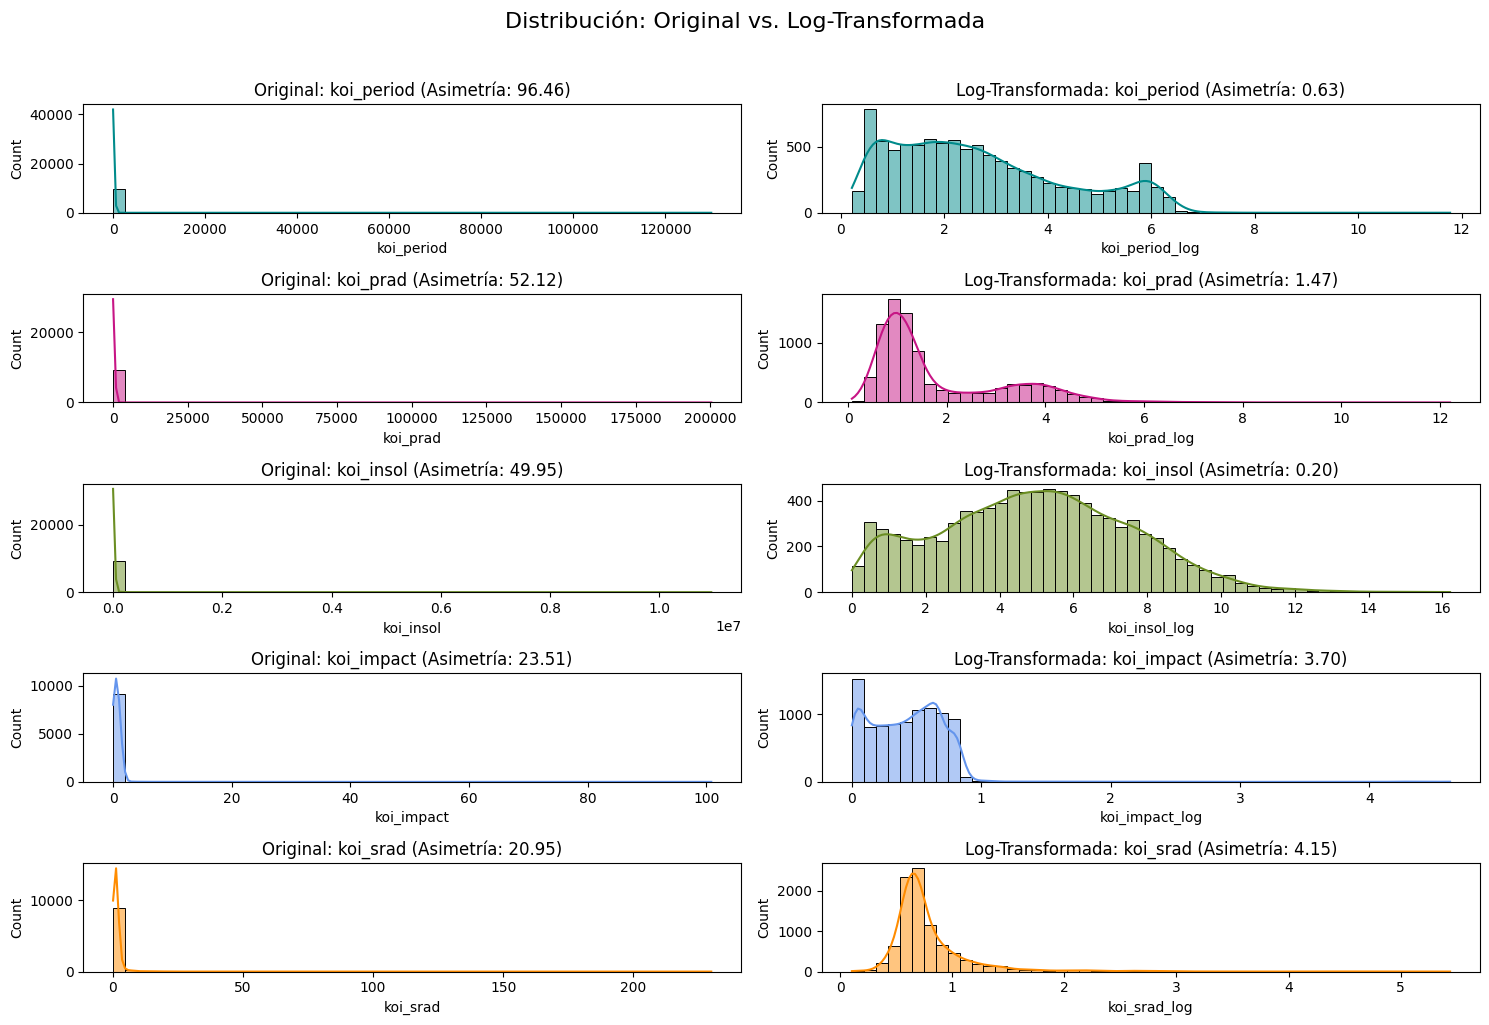

In [59]:
colores_fila = ['darkcyan', 'mediumvioletred', 'olivedrab', 'cornflowerblue', 'darkorange']

# Visualizar la distribución antes y despues de la transformación
fig, axes = plt.subplots(len(top_asimetrias), 2, figsize=(15, 10))
plt.suptitle('Distribución: Original vs. Log-Transformada', y=1.02, fontsize=16)

for i, col in enumerate(top_asimetrias):
    color_base = colores_fila[i % len(colores_fila)]
    # Columna original
    sns.histplot(df_copy2[col].dropna(), bins=50, kde=True, ax=axes[i, 0], color=color_base)
    axes[i, 0].set_title(f'Original: {col} (Asimetría: {df_copy2[col].skew():.2f})')
    
    # Columna Log-Transformada
    sns.histplot(df_log[f'{col}_log'].dropna(), bins=50, kde=True, ax=axes[i, 1], color=color_base)
    axes[i, 1].set_title(f'Log-Transformada: {col} (Asimetría: {df_log[f"{col}_log"].skew():.2f})')

plt.tight_layout()
plt.show()

Para manejar el sesgo a la derecha observado en las distribuciones, se aplicó la transformación logarítmica $log(1+x)$ a las variables con mayor asimetría: 

*koi_period, koi_prad, koi_insol, koi_impact y koi_srad*

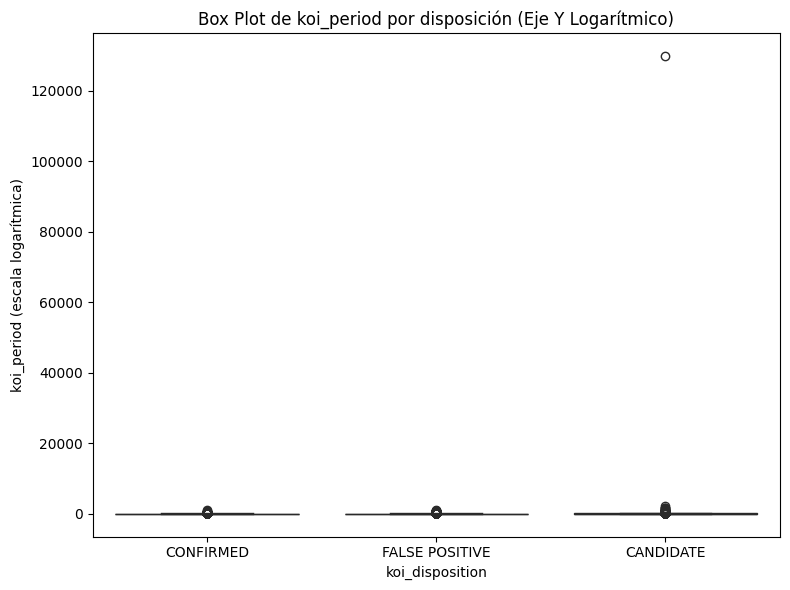

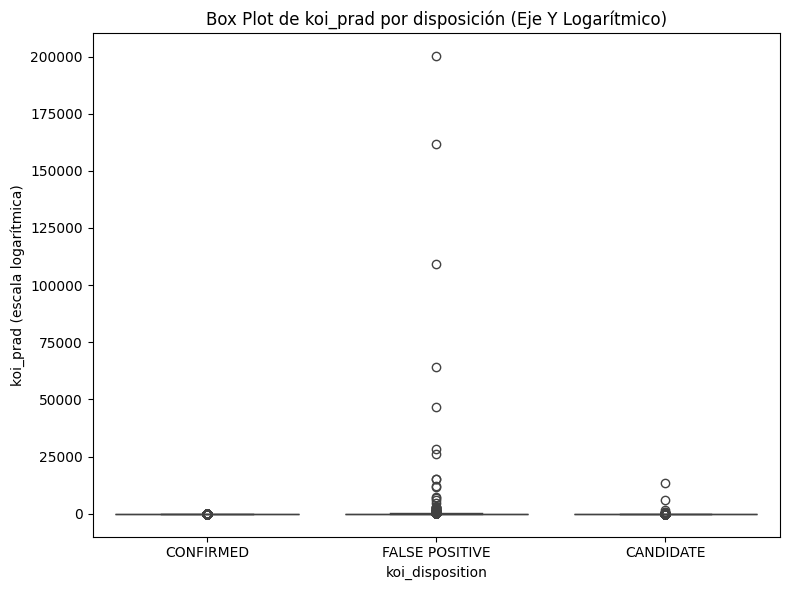

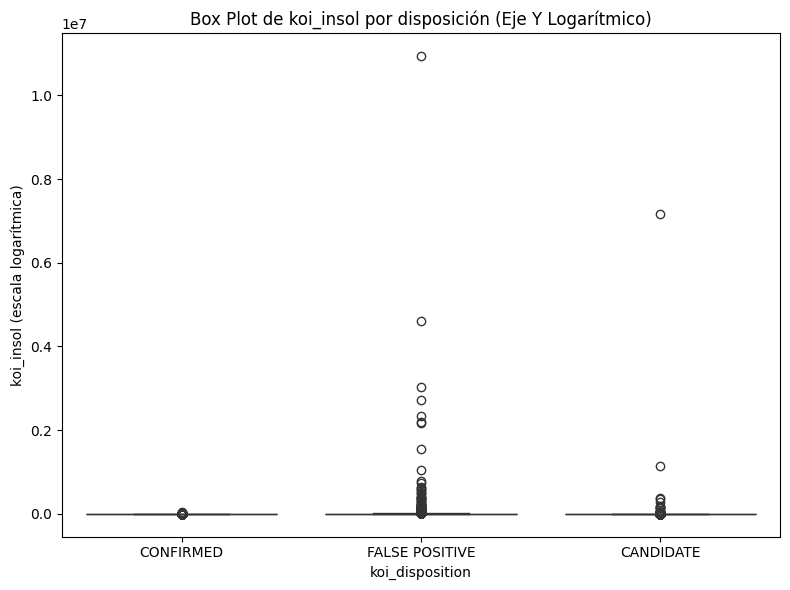

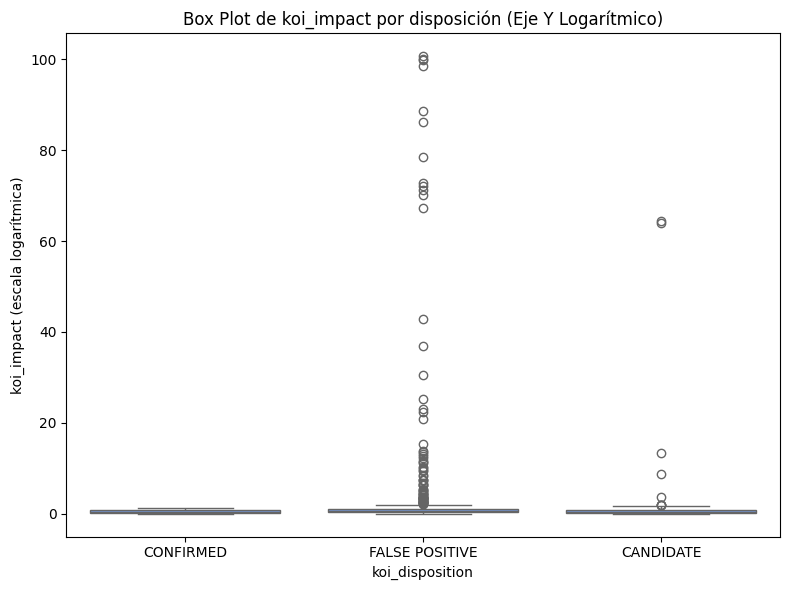

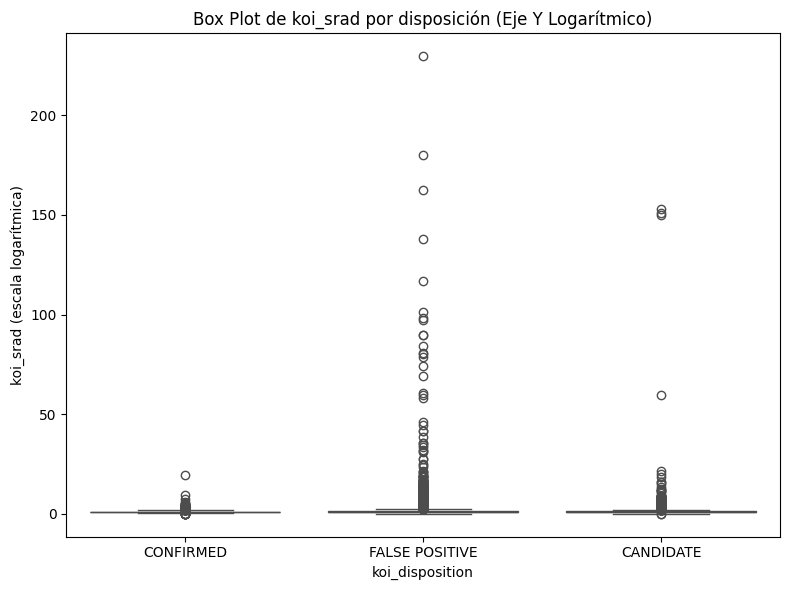

<Figure size 640x480 with 0 Axes>

In [63]:
for i, col in enumerate(top_asimetrias):
    color_base = colores_fila[i % len(colores_fila)]
    plt.figure(figsize=(8, 6))
    sns.boxplot(y=col, x='koi_disposition', data=df_copy2, color = color_base)
 
    plt.title(f'Box Plot de {col} por disposición (Eje Y Logarítmico)')
    plt.xlabel('koi_disposition')
    plt.ylabel(f'{col} (escala logarítmica)')
    
    plt.tight_layout()
    plt.show()

plt.tight_layout()
plt.show()

Al intentar visualizar estas variables en una escala lineal en los box plots, observamos que el rango generado por los outliers provoca:
* Pérdida de información central, ya que la caja representa el 50% de los datos (IQR)
*La visualización se comprime en una línea delgada, lo que la hace indistinguible, haciendo imposible identificar la mediana y la dispersión central (Q1 y Q3)

Para resolver esta limitación, aplicamos la transformación log(1+x) al eje Y de los box plots

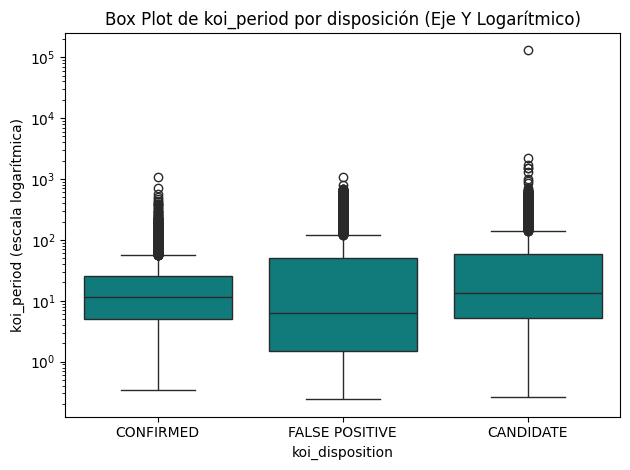

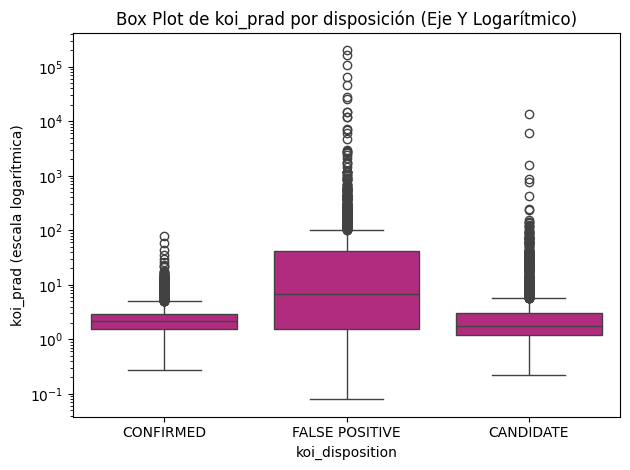

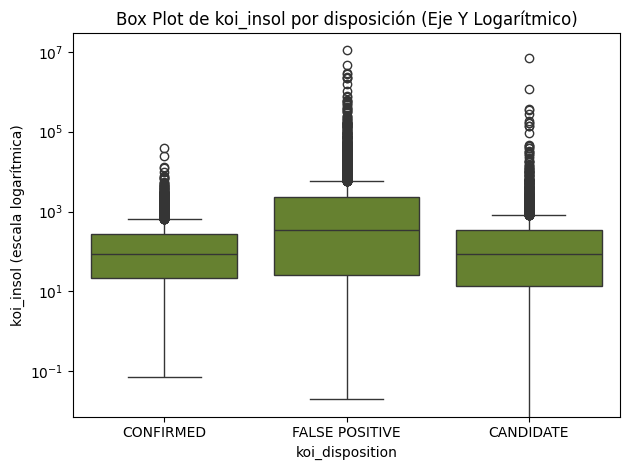

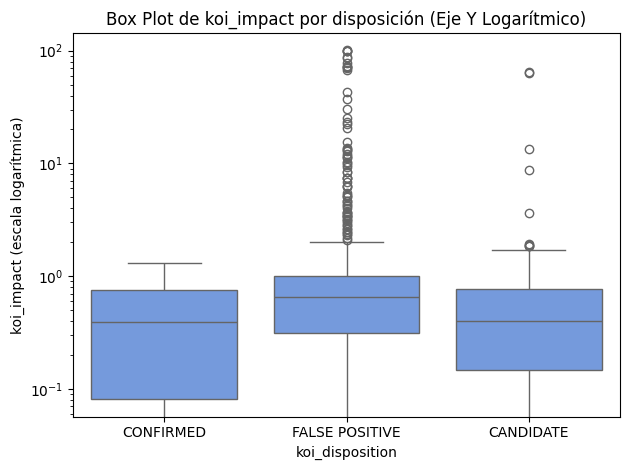

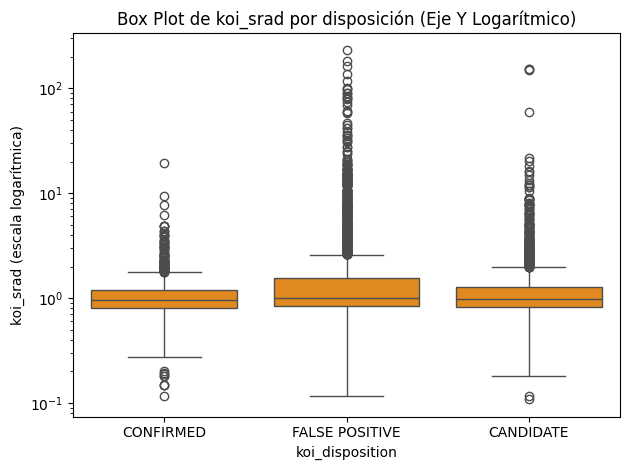

In [ ]:
for i, col in enumerate(top_asimetrias):
    color_base = colores_fila[i % len(colores_fila)]
    sns.boxplot(y=col, x='koi_disposition', data=df_copy2, color = color_base)
    
    # escala logarítmica en el eje Y
    plt.yscale('log')
    
    plt.title(f'Box Plot de {col} por disposición (Eje Y Logarítmico)')
    plt.xlabel('koi_disposition')
    plt.ylabel(f'{col} (escala logarítmica)')
    
    # Mostrar la figura
    plt.tight_layout()
    plt.show()

### Limitación a valores de outliers (capping)

Si bien puede haber valores altos físicamente posibles, existen algunos que son extremos o incluso sospechosos de errores en el catálogo (ej. koi_teq máximo = 14667 K, y valores gigantes de koi_prad)

En lugar de eliminar estas observaciones (ya que resultaría en una pérdida significativa de datos válidos), aplicaremos el método de capping, lo que nos ayuda a limitar el "peso" de estos.

Vamos a limita los valores que aún hayan quedado en las colas de la distribución logarítmica

Para ello, definimos un umbral utilizando el IQR con un escalar $k=3.0$ tal que $k=3(Q3 + 3 * IQR)$

La función iqr_capper se encuentra previamente definida en la sección "Funciones auxiliares"

In [75]:
# Usaremos k = 300.0 
k = 300.0
for i in top_asimetrias:
    # Aplicamos la función iqr_capper a koi_teq
    df_log_cap = iqr_capper(df_log, i, factor=k)

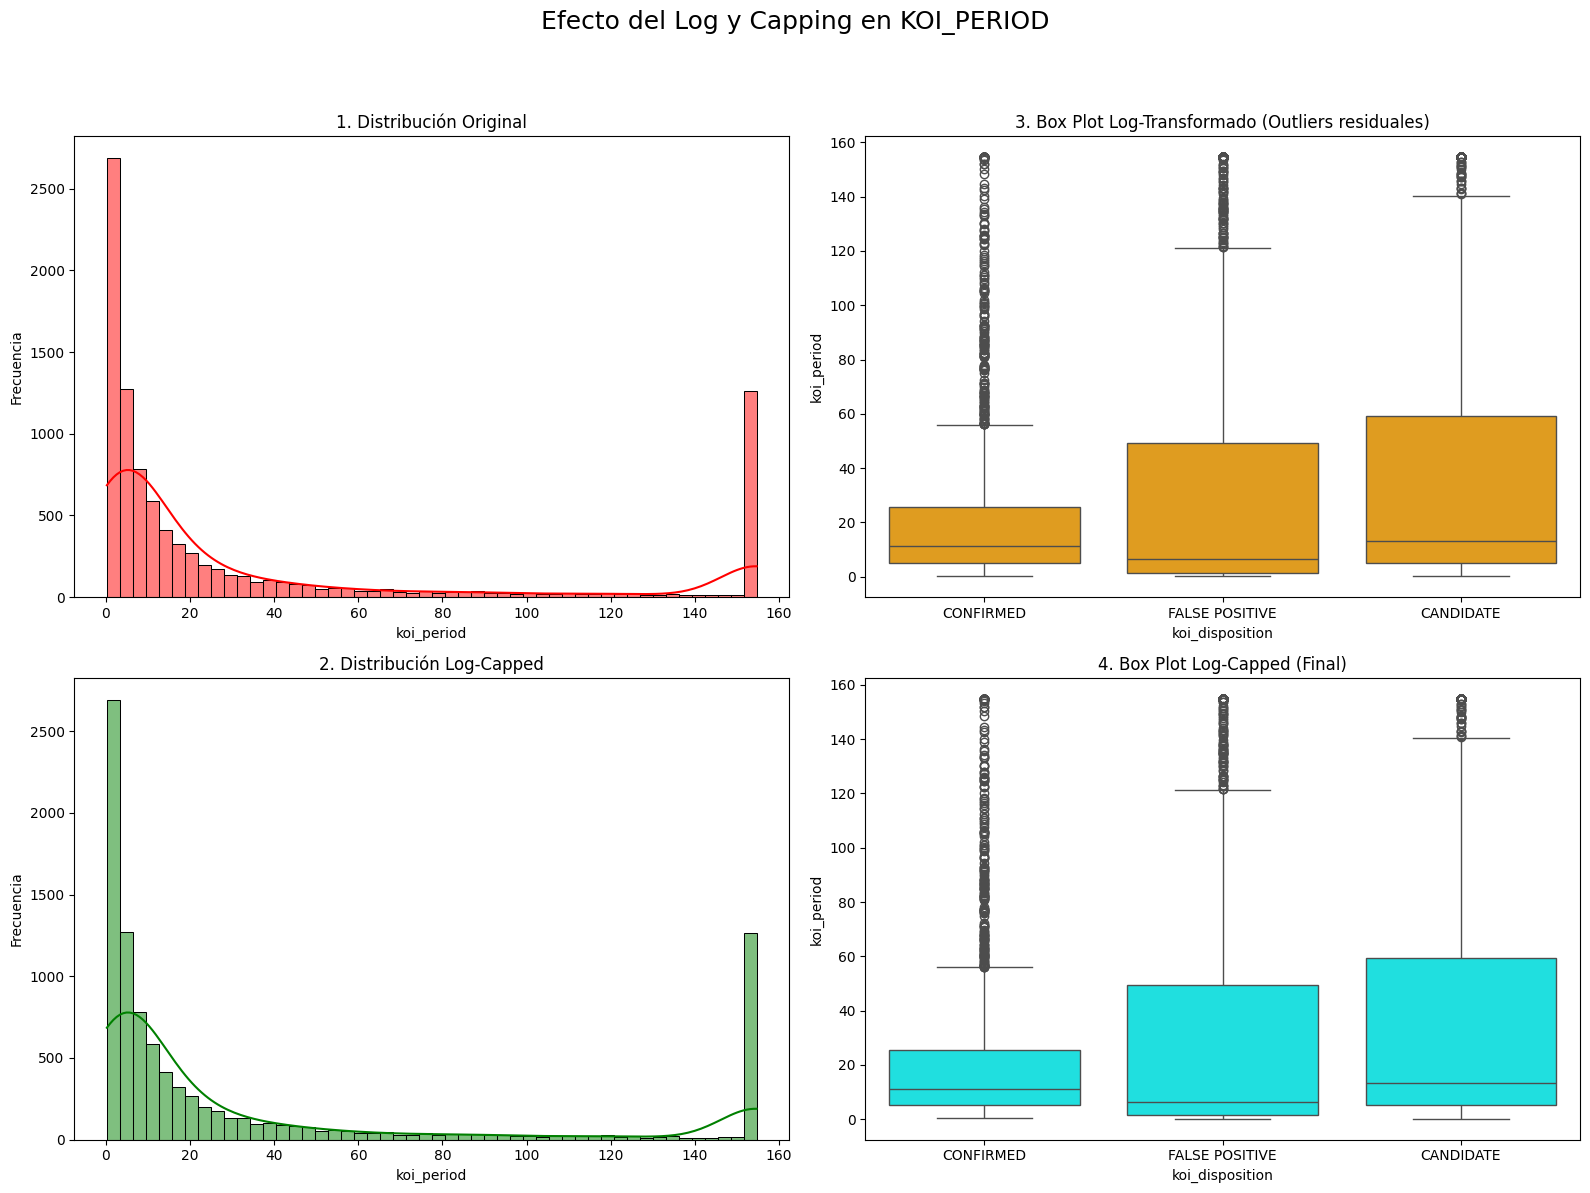

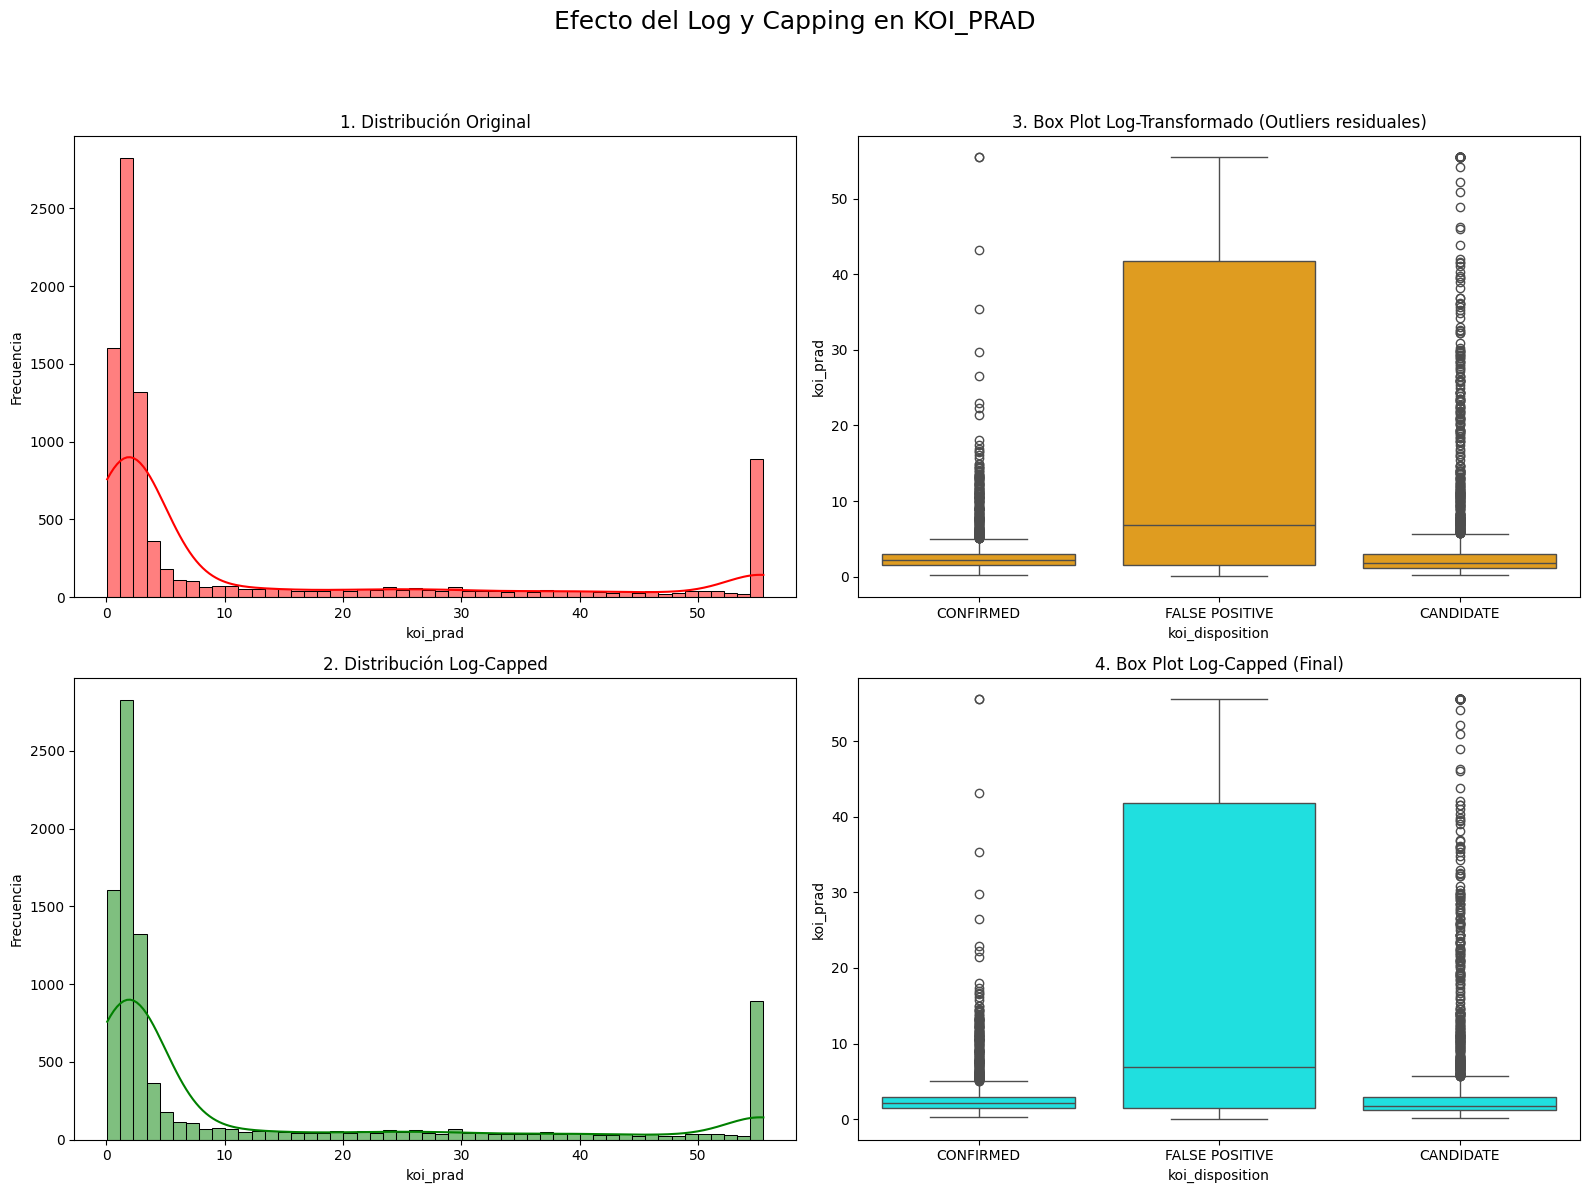

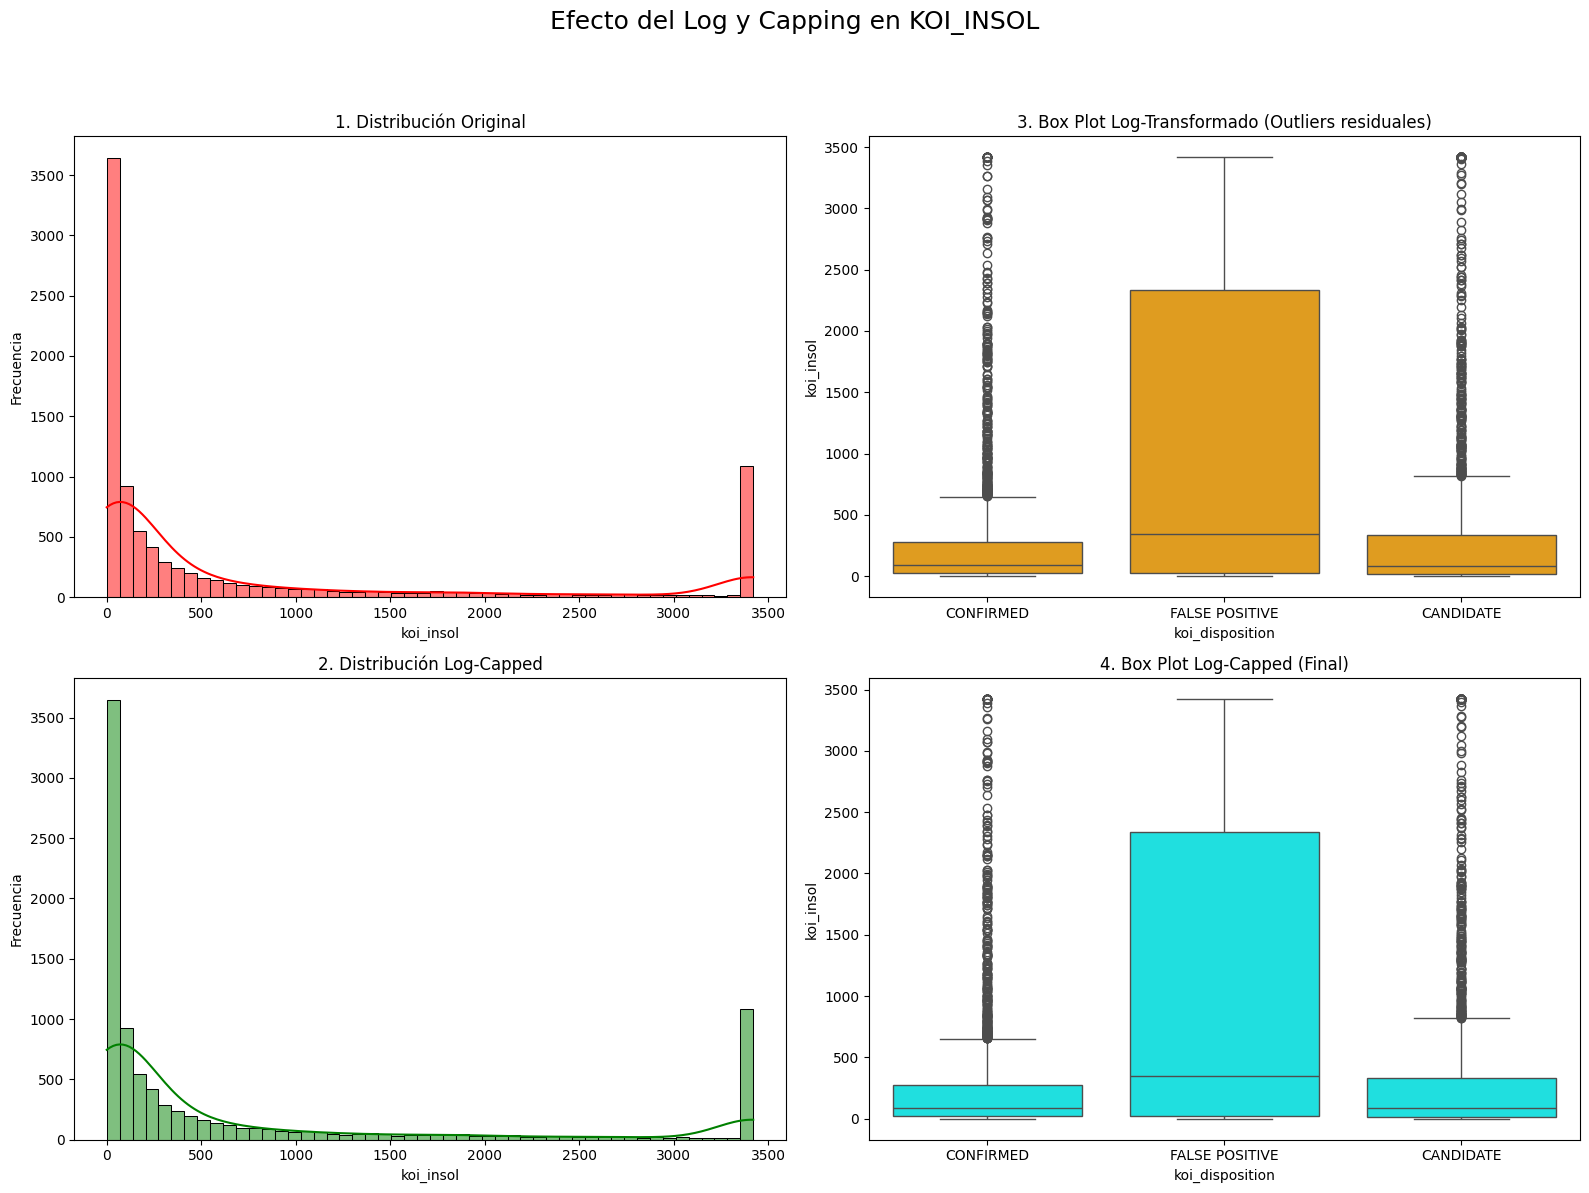

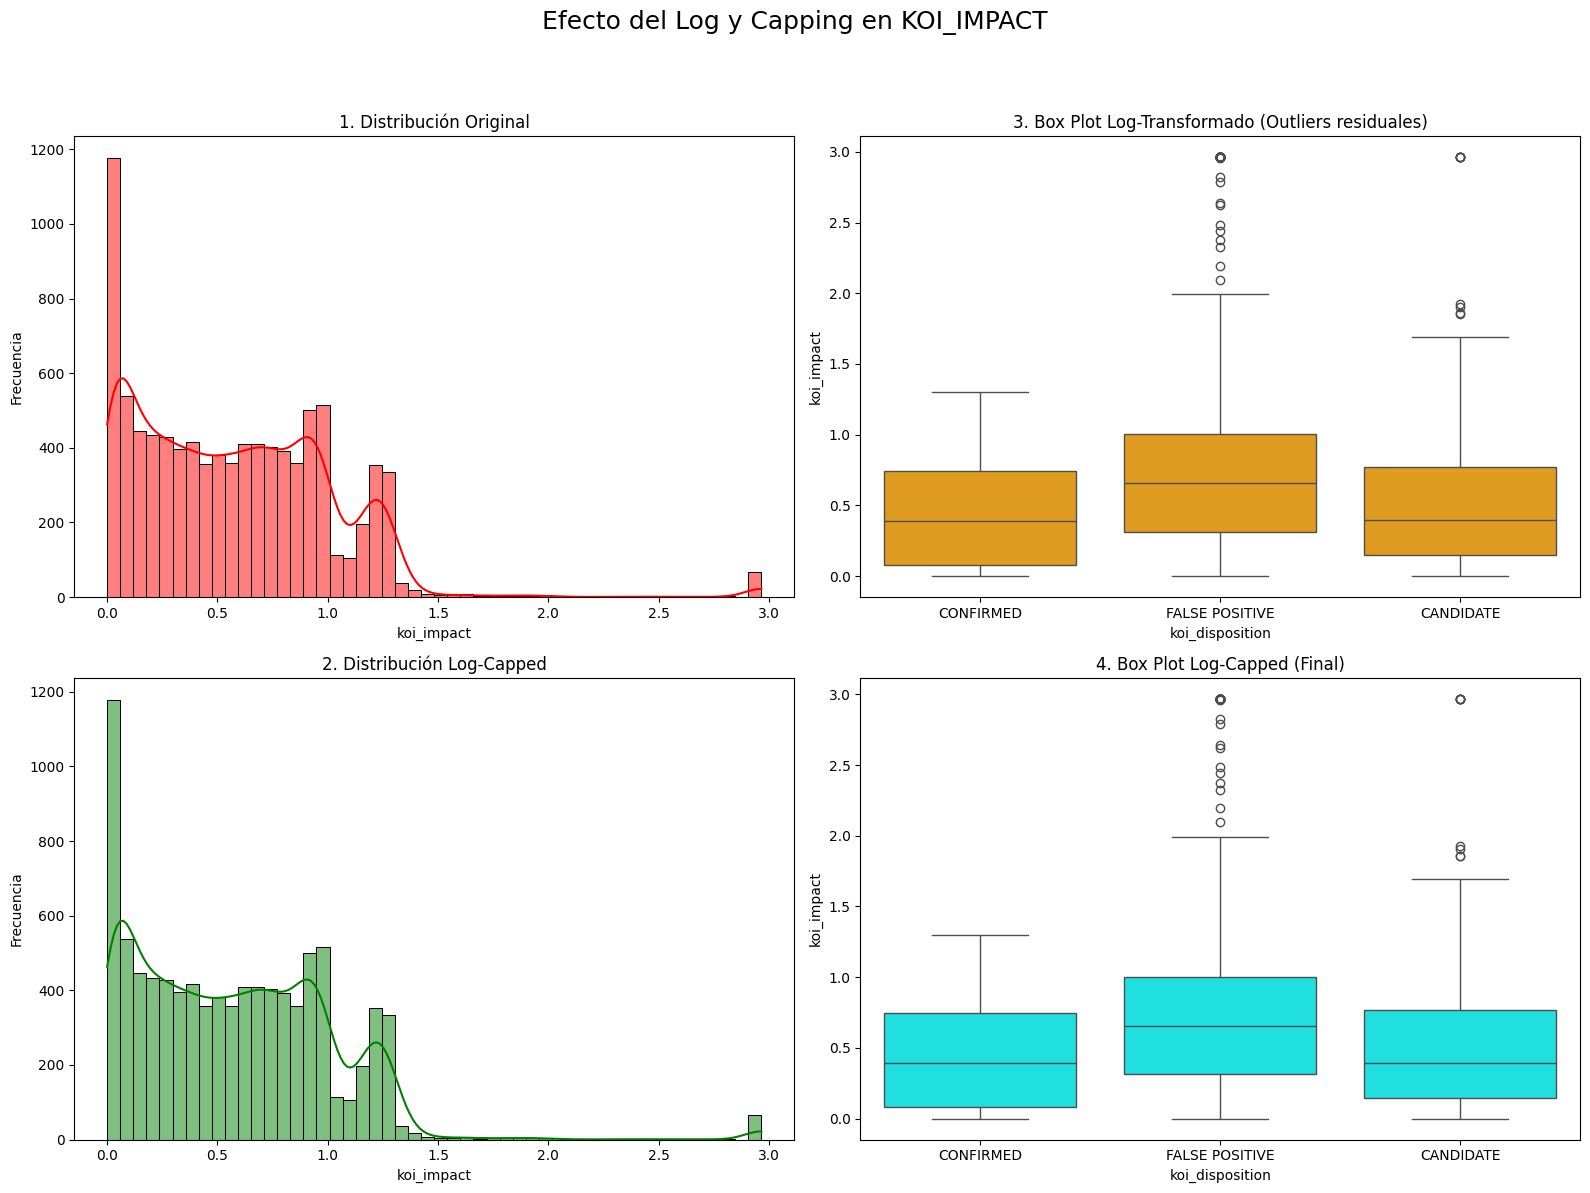

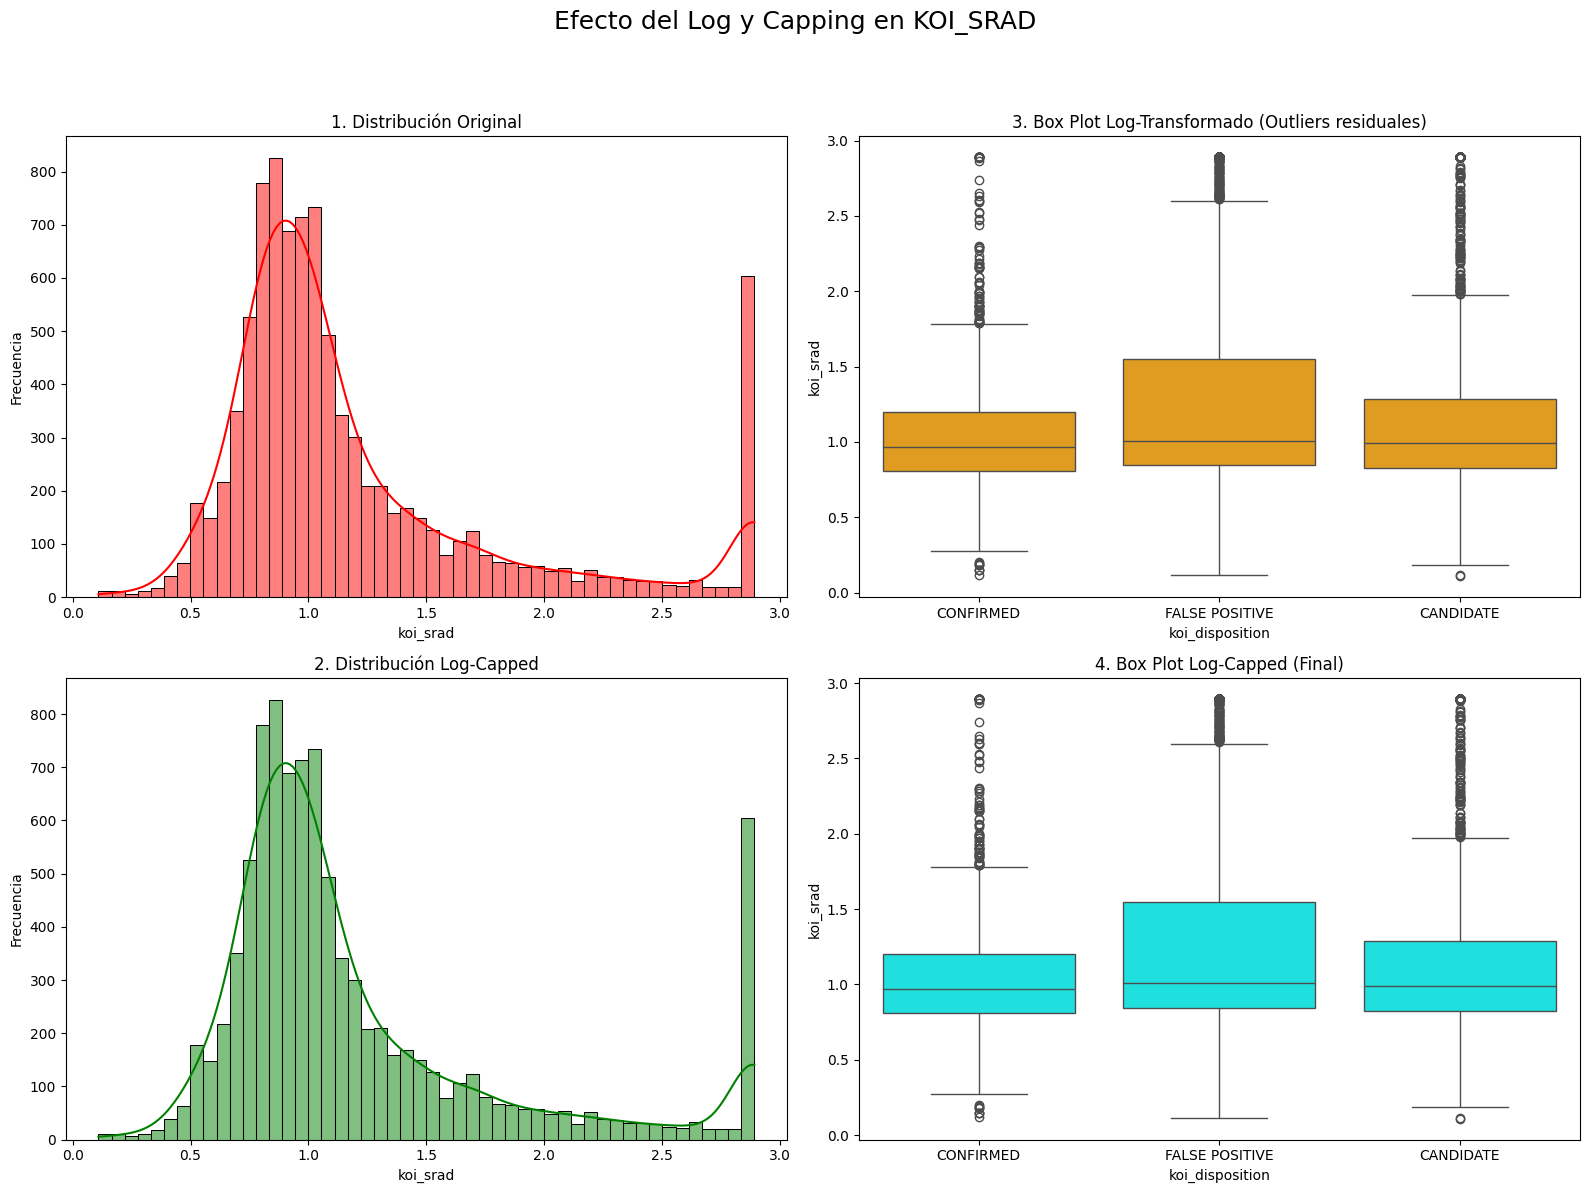

In [76]:
for variable in top_asimetrias:

    plt.figure(figsize=(16, 12))
    plt.suptitle(f'Efecto del Log y Capping en {variable.upper()}', fontsize=18, y=1.02)

    # Histograma de la Variable Original 
    plt.subplot(2, 2, 1)
    sns.histplot(df_log[variable], bins=50, kde=True, color='red')
    plt.title(f'1. Distribución Original')
    plt.xlabel(variable)
    plt.ylabel('Frecuencia')

    # Histograma de la Variable Log-Capped 
    plt.subplot(2, 2, 3)
    sns.histplot(df_log_cap[variable], bins=50, kde=True, color='green')
    plt.title(f'2. Distribución Log-Capped')
    plt.xlabel(variable)
    plt.ylabel('Frecuencia')

    # Box Plot de la Variable Log-Transformada (ANTES del Capping)
    plt.subplot(2, 2, 2)
    sns.boxplot(y=df_log[variable], x=df_log_cap['koi_disposition'], color='orange')
    plt.title('3. Box Plot Log-Transformado (Outliers residuales)')
    plt.ylabel(variable)

    # Box Plot de la Variable Log-Capped (FINAL) 
    plt.subplot(2, 2, 4)
    sns.boxplot(y=df_log_cap[variable], x=df_log_cap['koi_disposition'], color='cyan')
    plt.title('4. Box Plot Log-Capped (Final)')
    plt.ylabel(variable)

    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.show() 

## OneHot Encoding

Una vez que se han manejado los valores nulos, así como los outliers, utilizaremos CustomOneHotEncoder para representar como vectores las columnas categóricas

In [146]:
one_hot_encoder = OneHotEncoder()

In [ ]:
X_df_encoded = one_hot_encoder.fit_transform(X_df_imputed)

## Cálculo de Correlaciones

In [ ]:
# Transformamos la variable de salida a numérica para calcular correlaciones
X_df_copy = X_df.join(y_df)
X_df_copy["koi_disposition"] = X_df_copy["koi_disposition"].factorize()[0]

In [ ]:
# Calculamos correlaciones
corr_matrix = X_df_copy.corr()
corr_matrix["koi_disposition"].sort_values(ascending=False)

In [ ]:
X_df_copy.corr()

In [ ]:
# Se puede llegar a valorar quedarnos con aquellas que tienen mayor correlación
corr_matrix[corr_matrix["koi_disposition"] > 0.05]

## Reducción del número de características

In [ ]:
# Extraemos las 12 caracteristicas con mas relevancia para el algoritmo
columns = list(corr_matrix[corr_matrix["koi_disposition"] > 0.05].index)
columns.remove("koi_disposition")

In [ ]:
columns

In [ ]:
X_df_reduced = X_df_copy[columns].copy()

In [ ]:
X_df_reduced

In [ ]:
df_prep = X_df_reduced.join(y_df)

In [ ]:
df_prep

## División del conjunto de datos no reducido

In [ ]:
train_set, val_set, test_set = train_val_test_split(X_df_copy)

In [ ]:
X_train, y_train = remove_labels(train_set, 'koi_disposition')
X_val, y_val = remove_labels(val_set, 'koi_disposition')
X_test, y_test = remove_labels(test_set, 'koi_disposition')

## Random Forests

Este modelo de clasificación se ha implementado sobre el conjunto de datos no reducido

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf_rnd = RandomForestClassifier(n_estimators=10000, random_state=42, n_jobs=-1)
clf_rnd.fit(X_train, y_train)

In [ ]:
# Predecimos con el conjunto de datos de entrenamiento
y_train_pred = clf_rnd.predict(X_train)

In [ ]:
print("F1 Score Train Set:", f1_score(y_train_pred, y_train, average='weighted'))

In [ ]:
# Predecimos con el conjunto de datos de validación
y_val_pred = clf_rnd.predict(X_val)

In [ ]:
print("F1 Score Validation Set:", f1_score(y_val_pred, y_val, average='weighted'))

In [ ]:
# Predecimos con el conjunto de datos de prueba
y_test_pred = clf_rnd.predict(X_test)

In [ ]:
print("F1 Score Validation Set:", f1_score(y_test_pred, y_test, average='weighted'))